In [1]:
#import relevant packages
from netCDF4 import Dataset
import os
import datetime
import xarray as xr
import xradar as xd
import act
import matplotlib.pyplot as plt
import cmweather
import numpy as np
import pandas as pd
import pywt
from scipy.signal import convolve2d, medfilt, find_peaks
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d
from statsmodels.tsa.stattools import acf
import glob
from metpy.calc import potential_temperature, wind_components
from metpy.units import units

%matplotlib inline

In [2]:
#calculate velocity variance by applying a convolution
def get_velocity_variance(ds, window=(3, 3), field='radial_velocity'):

    #try different window 
    """

    Gets the velocity variance over the prescribed window from the
    xarray dataset

    Parameters
    ----------
    ds: xarray Dataset
        The lidar dataset.
    window: (int, int) tuple
        The (range x time) window to perform the standard deviation on.
    field: str
        The mean doppler velocity field.
    """

    conv_kernel = 1 / (window[0] * window[1]) * np.ones(window)
    mean_vel = convolve2d(ds[field], conv_kernel, mode='same')
    variance = convolve2d((ds[field] - mean_vel) ** 2, conv_kernel, mode='same')
    ds['velocity_variance'] = (['time', 'range'], variance)
    return ds


In [5]:
ds_stare = xr.open_mfdataset('/Users/rjackson/Downloads/20240722/*Stare*.nc', combine='nested', concat_dim='time')
ds_stare = ds_stare.sortby('time').load()

In [6]:
def get_variances(input_ds):
    dt_range = pd.date_range(input_ds['time'].values[0], input_ds['time'].values[-1], periods=
                         int((input_ds['time'].values[-1] - input_ds['time'].values[0])/0.5e9))
    nperiods = len(dt_range)
    print(nperiods)
    inp_ds = input_ds.reindex(time=dt_range, method='nearest', tolerance=np.timedelta64(1, 's'))
    
    time_10min = inp_ds["time"].resample(time="10min").min().values
    noise_variance = np.zeros((time_10min.shape[0], len(inp_ds['range'])))
    atmos_variance = np.zeros_like(noise_variance)
    w_25 = np.zeros_like(noise_variance)
    w_50 = np.zeros_like(noise_variance)
    w_75 = np.zeros_like(noise_variance)
    skewy = np.zeros_like(noise_variance)
    kurty = np.zeros_like(noise_variance)
    scale = np.zeros_like(noise_variance)
    w_min = np.zeros_like(w_25)
    w_max = np.zeros_like(w_min)
    variance = np.zeros_like(noise_variance)
    for i, j in enumerate(range(0, nperiods, 1200)):
        print(j)
        for k in range(0, len(inp_ds['range'])):
            series = inp_ds['radial_velocity'].values[j:min([j+3600, nperiods]), k]
            series_intensity = inp_ds['intensity'].values[j:min([j+3600, nperiods])]
            t = inp_ds['time'].values[j:min([j+3600, nperiods])].astype(float) * 1e-9
            t = t[np.isfinite(series)]
            series = series[np.isfinite(series)]
            
            if len(series) == 0:
                continue
            try:
                v_acf = acf(series, nlags=5)
            except ValueError:
                variance[i, k] = np.nan
                noise_variance[i, k] = np.nan
                atmos_variance[i, k] = np.nan
                w_25[i, k] = np.nan
                w_50[i, k] = np.nan
                w_75[i, k] = np.nan
                w_min[i, k] = np.min(series)
                w_max[i, k] = np.max(series)
                continue
            variance[i, k] = np.var(series)
            wprime = series - np.nanmean(series)
            skewy[i, k] = skew(wprime)
            kurty[i, k] = kurtosis(wprime)
            
                
            noise_variance[i, k] = (v_acf[0] - v_acf[1]) * variance[i, k]
            atmos_variance[i, k] = variance[i, k] - noise_variance[i, k]
            w_25[i, k] = np.percentile(series, 0.25)
            w_50[i, k] = np.percentile(series, 0.5)
            w_75[i, k] = np.percentile(series, 0.75)
            w_min[i, k] = np.min(series)
            w_max[i, k] = np.max(series)
            
    variance = xr.DataArray(variance, dims=["time", "range"])
    variance.attrs["long_name"] = "Total variance"
    variance.attrs["units"] = "m s-1"
    noise_variance = xr.DataArray(noise_variance, dims=["time", "range"])
    noise_variance.attrs["long_name"] = "Variance due to noise"
    noise_variance.attrs["units"] = "m s-1"
    atmos_variance = xr.DataArray(atmos_variance, dims=["time", "range"])
    atmos_variance.attrs["long_name"] = "Variance due to signal"
    atmos_variance.attrs["units"] = "m s-1"
    w_25 = xr.DataArray(w_25, dims=["time", "range"])
    w_25.attrs["long_name"] = "25th percentile of w"
    w_25.attrs["units"] = "m s-1"
    w_50 = xr.DataArray(w_50, dims=["time", "range"])
    w_50.attrs["long_name"] = "50th percentile of w"
    w_50.attrs["units"] = "m s-1"
    w_75 = xr.DataArray(w_75, dims=["time", "range"])
    w_75.attrs["long_name"] = "75th percentile of w"
    w_75.attrs["units"] = "m s-1"
    w_min = xr.DataArray(w_min, dims=["time", "range"])
    w_min.attrs["long_name"] = "Minimum w"
    w_min.attrs["units"] = "m s-1"
    w_max = xr.DataArray(w_max, dims=["time", "range"])
    w_max.attrs["long_name"] = "Maximum w"
    w_max.attrs["units"] = "m s-1"
    skewy = xr.DataArray(skewy, dims=["time", "range"])
    skewy.attrs["long_name"] = "Skewness"
    skewy.attrs["units"] = "m^3 s^-3"
    kurty = xr.DataArray(kurty, dims=["time", "range"])
    kurty.attrs["long_name"] = "Kurtosis"
    kurty.attrs["units"] = "m^4 s^-4"
    scale = xr.DataArray(scale, dims=["time", "range"])
    scale.attrs["long_name"] = "Integral scale"
    scale.attrs["units"] = "s"
    variance_ds = xr.Dataset({'time': time_10min,
                              'range': inp_ds["range"],
                              'variance': variance,
                              'noise_variance': noise_variance,
                              'atmos_variance': atmos_variance,
                              'w_25': w_25, 'w_min': w_min,
                              'w_50': w_50, 'w_max': w_max,
                              'w_75': w_75, 'skewness': skewy,
                              'kurtosis': kurty, 'scale': scale})

    return variance_ds

In [ ]:
variance_ds = get_variances(ds_stare.sortby('time'))

In [29]:
variance_ds.to_netcdf('variances.nc')

In [126]:
ds_stare['time'].values[0:1]

array(['2024-07-22T00:00:00.420012000'], dtype='datetime64[ns]')

(0.0, 2000.0)

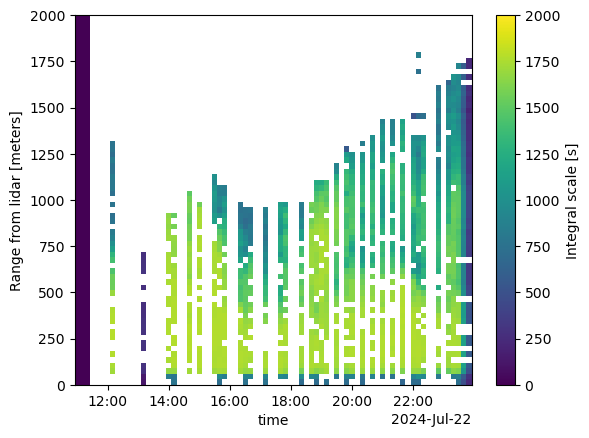

In [37]:
variance_ds['scale'].sel(
    time=slice('2024-07-22T11:00:00', '2024-07-23T00:00:00')).where(
    variance_ds['noise_variance'] < 0.2).T.plot(vmin=0, vmax=2000)
plt.ylim([0, 2000])

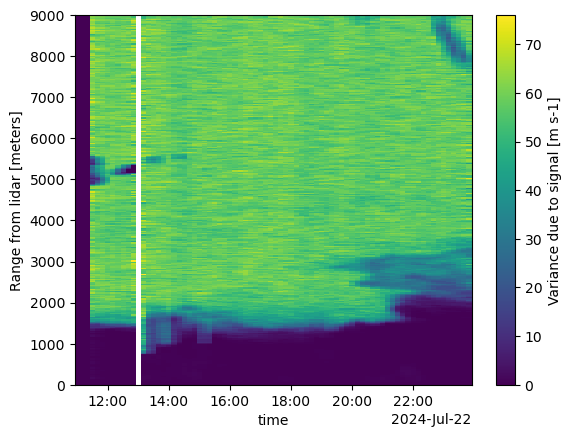

In [11]:
variance_ds['atmos_variance'].sel(time=slice('2024-07-22T11:00:00', '2024-07-23T00:00:00')).T.plot()

Filter out noise variance > 1 m/s

/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2007: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_83377/2428514043.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_83377/2428514043.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Velocity_variance.png', bbox_inches='tight')


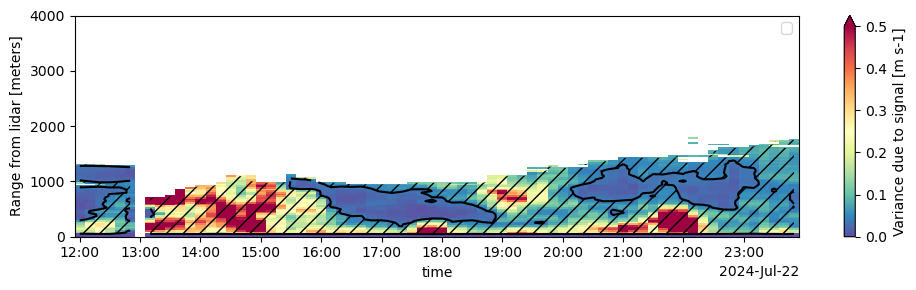

In [195]:
plt.figure(figsize=(10, 3))
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T00:00:00')).T.plot(cmap='Spectral_r', vmin=0, vmax=0.5)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T00:00:00')).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T00:00:00')).T.plot.contour(
       levels=[0.04], colors=['k'], add_colorbar=False, label='PBL Tucker method')
plt.ylim([0, 4000])
plt.ylim([0, 4000])
plt.legend()
plt.tight_layout()

plt.savefig('Velocity_variance.png', bbox_inches='tight')

In [12]:
pblh_lidar = np.zeros(variance_ds.sizes['time'])
pbl_mask = variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).values < 0.04
pbl_mask = pbl_mask[:, 3:]
for i in range(len(pblh_lidar)):
    try:
        pbl_ind = np.argwhere(pbl_mask[i, :])[0]
        pblh_lidar[i] = variance_ds['range'].values[pbl_ind+2]
    except IndexError:
        pblh_lidar[i] = np.nan

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/4120443724.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pblh_lidar[i] = variance_ds['range'].values[pbl_ind+2]


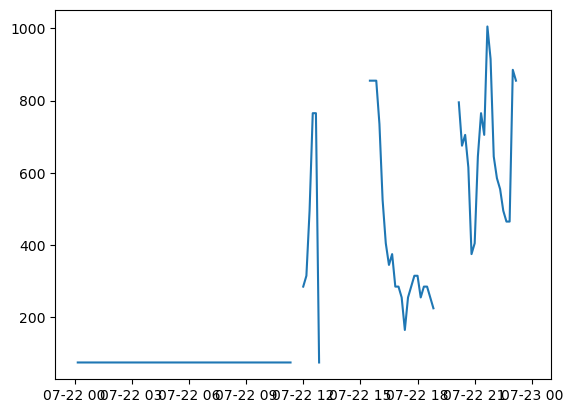

In [60]:
plt.plot(variance_ds['time'].values, pblh_lidar)

<>:31: SyntaxWarning: invalid escape sequence '\ '
<>:46: SyntaxWarning: invalid escape sequence '\ '
<>:65: SyntaxWarning: invalid escape sequence '\ '
<>:31: SyntaxWarning: invalid escape sequence '\ '
<>:46: SyntaxWarning: invalid escape sequence '\ '
<>:65: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_30202/3928503037.py:31: SyntaxWarning: invalid escape sequence '\ '
  plt.colorbar(c, ax=ax[0], label="$log_{10}\ P(l)$")
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_30202/3928503037.py:46: SyntaxWarning: invalid escape sequence '\ '
  plt.colorbar(c, ax=ax[1], label="$log_{10}\ P(l)$")
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_30202/3928503037.py:65: SyntaxWarning: invalid escape sequence '\ '
  plt.colorbar(c, ax=ax[2], label="$log_{10}\ P(l)$")
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_30202/3928503037.py:4: RuntimeWarning: divide by zero encountered in divide
  fftfreq = 5 / 

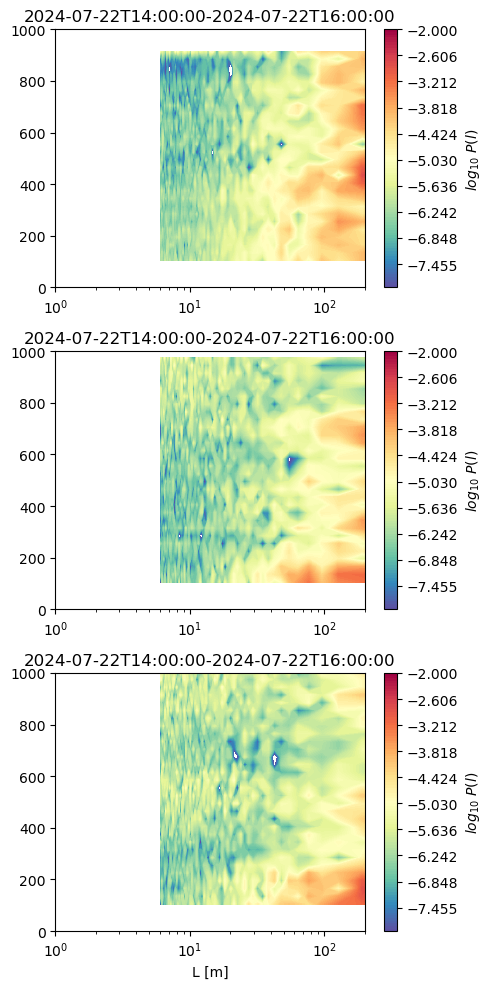

In [55]:
freq = 0.6
nfft = 128
fftfreq = np.fft.fftfreq(128, freq)
fftfreq = 5 / fftfreq
fftfreq[~np.isfinite(fftfreq)] = 300.
start_time1 = '2024-07-22T14:00:00'
end_time1 = '2024-07-22T16:00:00'
start_time2 = '2024-07-22T16:00:00'
end_time2 = '2024-07-22T19:00:00'
start_time3 = '2024-07-22T19:00:00'
end_time3 = '2024-07-22T20:00:00'
start_time3 = '2024-07-22T20:00:00'
end_time3 = '2024-07-22T23:00:00'

fig, ax = plt.subplots(3, 1, figsize=(5, 10))
spectra = np.zeros((ds_stare.sizes["range"] - 3, int(nfft/2) ))
x, y = np.meshgrid(fftfreq[:int(nfft/2)], ds_stare["range"].values[3:])
for i, lev in enumerate(ds_stare["range"].values[3:]):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time1, end_time1))
    wprime = wprime - wprime.mean(dim='time')
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    spectra[i, :] = spec[:int(nfft/2)]
    c = ax[0].contourf(x, y, np.log10(spectra), vmin=-8, vmax=-2,
                  cmap='Spectral_r', levels=np.linspace(-8, -2, 100))
ax[0].set_ylim([0, 1000])
#ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_title(start_time1 + '-' + end_time1)
plt.colorbar(c, ax=ax[0], label="$log_{10}\ P(l)$")
    
for i, lev in enumerate(ds_stare["range"].values[3:]):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time2, end_time2))
    wprime = wprime - wprime.mean(dim='time')
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    spectra[i, :] = spec[:int(nfft/2)]
c = ax[1].contourf(x, y, np.log10(spectra), vmin=-8, vmax=-2,
                    cmap="Spectral_r", levels=np.linspace(-8, -2, 100))
ax[1].set_ylim([0, 1000])
#ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_title(start_time1 + '-' + end_time1)
plt.colorbar(c, ax=ax[1], label="$log_{10}\ P(l)$")
    
for i, lev in enumerate(ds_stare["range"].values[3:]):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time3, end_time3))
    wprime = wprime - wprime.mean(dim='time')
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    spectra[i, :] = spec[:int(nfft/2)]
c = ax[2].contourf(x, y, np.log10(spectra), vmin=-8, vmax=-2,
                    cmap="Spectral_r", levels=np.linspace(-8, -2, 100))
ax[2].set_ylim([0, 1000])
ax[2].set_xlabel('L [m]')
ax[2].set_title(start_time1 + '-' + end_time1)
for i in range(0, 3):
    ax[i].set_xlim([1, 200])
    ax[i].set_xscale('log')
fig.tight_layout()
plt.colorbar(c, ax=ax[2], label="$log_{10}\ P(l)$")

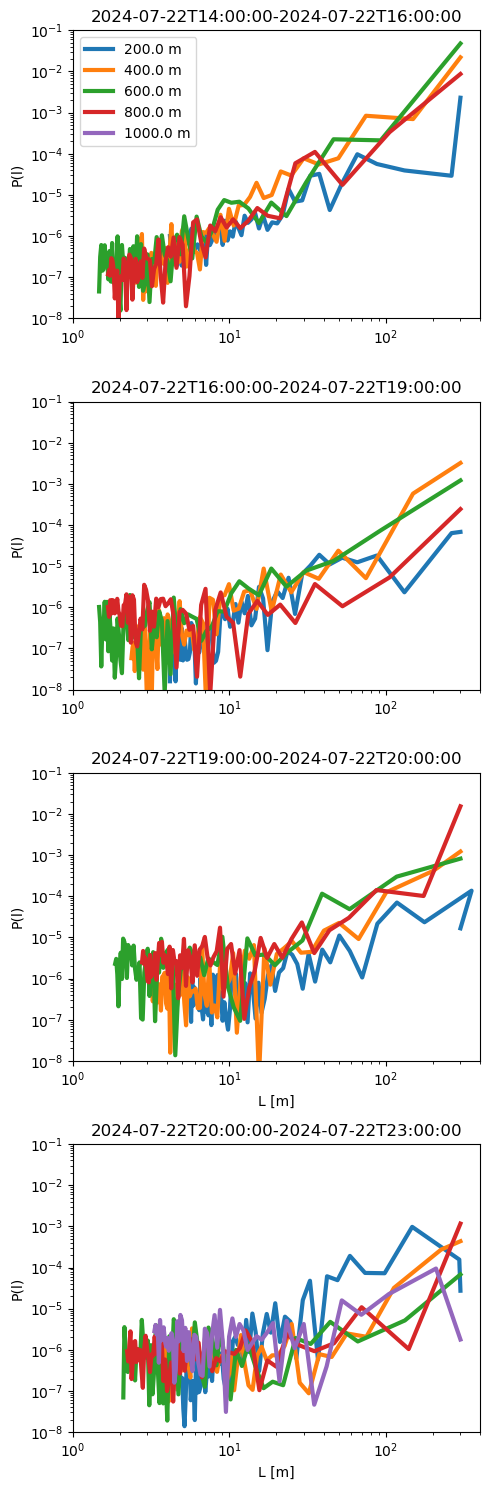

In [100]:
freq = 0.6
nfft = 128
fftfreq = np.fft.fftfreq(128, freq)
fftfreq = 5 / fftfreq
fftfreq[~np.isfinite(fftfreq)] = 300.
start_time1 = '2024-07-22T14:00:00'
end_time1 = '2024-07-22T16:00:00'
start_time2 = '2024-07-22T16:00:00'
end_time2 = '2024-07-22T19:00:00'
start_time3 = '2024-07-22T19:00:00'
end_time3 = '2024-07-22T20:00:00'
start_time4 = '2024-07-22T20:00:00'
end_time4 = '2024-07-22T23:00:00'
levels = [200., 400., 600., 800., 1000.]
fig, ax = plt.subplots(4, 1, figsize=(5, 15))
x, y = np.meshgrid(fftfreq[:int(nfft/2)], ds_stare["range"].values[3:])
for i, lev in enumerate(levels):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time1, end_time1))
    wprime = wprime - wprime.mean(dim='time')
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    fftfreq = np.fft.fftfreq(128, freq)
    speed = vert_profs["wind_speed"].where(
        vert_profs["residual"] < 0.75).sel(
        height=lev, method='nearest').sel(
        time=slice(start_time2, end_time2)).mean(dim="time").values
    fftfreq = speed / fftfreq
    fftfreq[~np.isfinite(fftfreq)] = 300.
    ax[0].plot(fftfreq[:int(nfft/2)], spec[:int(nfft/2)], label=str(lev) + " m", linewidth=3)
#ax[0].set_ylim([0, 1000])
ax[0].set_yscale('log')
ax[0].legend()
#ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_title(start_time1 + '-' + end_time1)
    
for i, lev in enumerate(levels):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time2, end_time2))
    wprime = wprime - wprime.mean(dim='time')
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    fftfreq = np.fft.fftfreq(128, freq)
    speed = vert_profs["wind_speed"].where(
        vert_profs["residual"] < 0.75).sel(
        height=lev, method='nearest').sel(
        time=slice(start_time2, end_time2)).mean(dim="time").values
    fftfreq = speed / fftfreq
    fftfreq[~np.isfinite(fftfreq)] = 300.
    ax[1].plot(fftfreq[:int(nfft/2)], spec[:int(nfft/2)], label=str(lev) + " m", linewidth=3)
#ax[1].set_ylim([0, 1000])
ax[1].set_yscale('log')
#ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_title(start_time2 + '-' + end_time2)
    
for i, lev in enumerate(levels):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time3, end_time3))
    wprime = wprime - wprime.mean(dim='time')
    fftfreq = np.fft.fftfreq(128, freq)
    speed = vert_profs["wind_speed"].where(
        vert_profs["residual"] < 0.75).sel(
        height=lev, method='nearest').sel(
        time=slice(start_time3, end_time3)).mean(dim="time").values
    fftfreq = speed / fftfreq
    fftfreq[~np.isfinite(fftfreq)] = 300.
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    ax[2].plot(fftfreq[:int(nfft/2)], spec[:int(nfft/2)], label=str(lev) + " m", linewidth=3)
#ax[2].set_ylim([0, 1000])
ax[2].set_yscale('log')
ax[2].set_xlabel('L [m]')
ax[2].set_title(start_time3 + '-' + end_time3)
for i in range(0, 3):
    ax[i].set_xlim([1, 400])
    ax[i].set_ylim([1e-8, 1e-1])
    ax[i].set_xscale('log')
    ax[i].set_ylabel('P(l)')

for i, lev in enumerate(levels):
    wprime = ds_stare['radial_velocity'].where(
        ds_stare['intensity'] > 1.013).sel(
        range=lev, method='nearest').sel(
        time=slice(start_time4, end_time4))
    wprime = wprime - wprime.mean(dim='time')
    fftfreq = np.fft.fftfreq(128, freq)
    speed = vert_profs["wind_speed"].where(
        vert_profs["residual"] < 0.75).sel(
        height=lev, method='nearest').sel(
        time=slice(start_time4, end_time4)).mean(dim="time").values
    fftfreq = speed / fftfreq
    fftfreq[~np.isfinite(fftfreq)] = 300.
    spec = 1 / (nfft * len(wprime)) * np.abs(np.fft.fft(wprime, nfft))**2
    ax[3].plot(fftfreq[:int(nfft/2)], spec[:int(nfft/2)], label=str(lev) + " m", linewidth=3)
#ax[2].set_ylim([0, 1000])
ax[3].set_yscale('log')
ax[3].set_xlabel('L [m]')
ax[3].set_title(start_time4 + '-' + end_time4)
for i in range(0, 4):
    ax[i].set_xlim([1, 400])
    ax[i].set_ylim([1e-8, 1e-1])
    ax[i].set_xscale('log')
    ax[i].set_ylabel('P(l)')
fig.tight_layout()

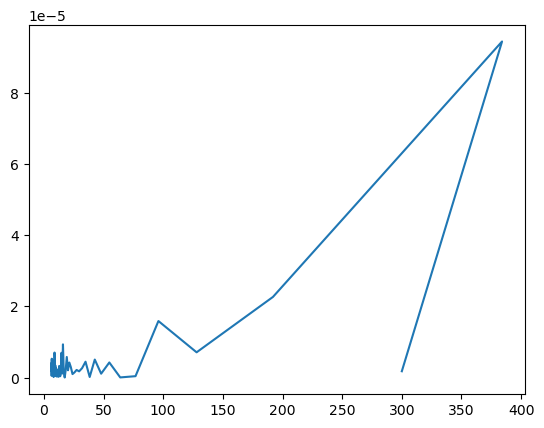

In [85]:
residual_thresh = 0.75
plot_every = 5
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-22T17:00:00')).T.plot(
    cmap='Spectral_r', vmin=0, vmax=0.5, ax=ax,
    cbar_kwargs={'label': '$\sigma_w$ [$m^{-2}\ s^{-2}]$'})
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T17:00:00')).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T17:00:00')).T.plot.contour(
       levels=[0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='k', marker='d', facecolors='none', edgecolors='black', linewidth=2, s=25,
        label="Harr wavelet Horiz. wind")
ax.set_ylim([0, 3000])
ax.legend()
fig.tight_layout()

fig.savefig('Velocity_variance.png', bbox_inches='tight')

In [40]:
variance_ds_1s = variance_ds.reindex(time=ds_stare.time, method='nearest')

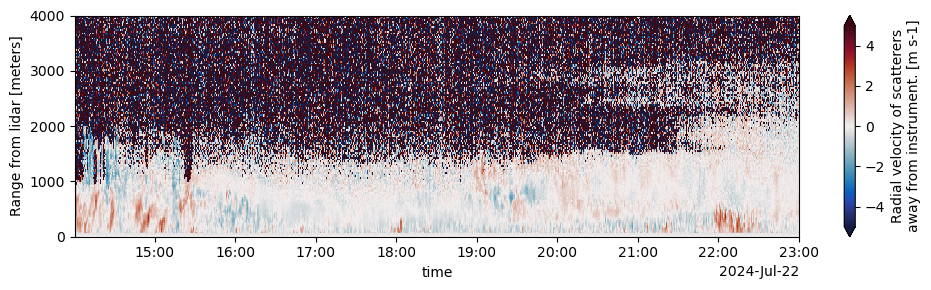

In [86]:
plt.figure(figsize=(10, 3))
ds_stare['radial_velocity'].sel(
    time=slice('2024-07-22T14:00:00', '2024-07-22T23:00:00')).T.plot(cmap='balance', vmin=-5, vmax=5)
plt.ylim([0, 4000])
plt.tight_layout()
plt.savefig('Vertical_velocity.png', bbox_inches='tight')

In [18]:
ds_vad = xr.open_mfdataset('/Users/rjackson/Downloads/20240722/*VAD*.nc', combine='nested', concat_dim='time')
ds_vad

<xarray.Dataset> Size: 7MB
Dimensions:          (time: 750, range: 300)
Coordinates:
  * range            (range) float64 2kB 15.0 45.0 75.0 ... 8.955e+03 8.985e+03
  * time             (time) datetime64[ns] 6kB 2024-07-22T11:54:48.960000 ......
    azimuth          (time) float64 6kB dask.array<chunksize=(6,), meta=np.ndarray>
    elevation        (time) float64 6kB dask.array<chunksize=(6,), meta=np.ndarray>
    pitch            (time) float64 6kB dask.array<chunksize=(6,), meta=np.ndarray>
    roll             (time) float64 6kB dask.array<chunksize=(6,), meta=np.ndarray>
Data variables:
    radial_velocity  (time, range) float64 2MB dask.array<chunksize=(6, 300), meta=np.ndarray>
    beta             (time, range) float64 2MB dask.array<chunksize=(6, 300), meta=np.ndarray>
    intensity        (time, range) float64 2MB dask.array<chunksize=(6, 300), meta=np.ndarray>
    spectral_width   (time, range) float64 2MB dask.array<chunksize=(6, 300), meta=np.ndarray>
    latitude         (time) float64 6kB 41.98 41.98 41.98 ... 41.98 41.98 41.98
    longitude        (time) float64 6kB -87.72 -87.72 -87.72 ... -87.72 -87.72
    altitude         (time) float64 6kB 176.5 176.5 176.5 ... 176.5 176.5 176.5
Attributes:
    Conventions:         CF-1.7
    version:             R0
    mentor:              Bobby Jackson
    mentor_email:        rjackson@anl.gov
    mentor_institution:  Argonne National Laboratory
    mentor_orcid:        0000-0003-2518-1234
    contributors:        Bobby Jackson, Scott Collis, Paytsar Muradyan, Max G...
    scan_type:           VAD

In [19]:
vert_profs = act.retrievals.compute_winds_from_ppi(ds_vad)
vert_profs

<xarray.Dataset> Size: 2MB
Dimensions:                (time: 125, height: 300)
Coordinates:
  * time                   (time) datetime64[ns] 1kB 2024-07-22T11:54:58.5649...
  * height                 (height) float64 2kB 9.642 28.93 ... 5.775e+03
Data variables:
    wind_speed             (time, height) float64 300kB nan 0.01111 ... 17.98
    wind_direction         (time, height) float64 300kB nan 120.0 ... nan 255.7
    wind_speed_error       (time, height) float64 300kB nan 0.03424 ... 8.557
    wind_direction_error   (time, height) float64 300kB nan 185.7 ... nan 16.31
    signal_to_noise_ratio  (time, height) float64 300kB 0.005771 ... 0.01174
    residual               (time, height) float64 300kB nan 0.01805 ... 2.901
    correlation            (time, height) float64 300kB nan 0.3333 ... 0.9102

In [87]:
vert_profs["wind_speed"].where(vert_profs["residual"] < 0.75).T.plot(vmax=10)
plt.ylim([0, 4000])

NameError: name 'vert_profs' is not defined

In [70]:
def harr_wavelet_transform(ds, var_name='wind_speed', range_name="height", scale=60.):
    level = int(scale/(ds[range_name].values[1] - ds[range_name].values[0])) - 1
    print(level)
    coeffs = pywt.wavedec(ds[var_name].values, 'haar', level=level)
    cA = coeffs[0]
    print(cA.shape)
    resampled_range = ds[range_name].values[::2**level]
    resampled_time = ds.time.values[::]
    
    ds["resampled_range"] = resampled_range
    ds["resampled_time"] = resampled_time
    
    ds = ds.set_coords(["resampled_range", "resampled_time"])
    
    ds["wavelet_backscatter"] = (("resampled_time", "resampled_range"), cA) 
    
    
    min_range = ds.wavelet_backscatter.diff("resampled_range").max("resampled_range")
    pbl_heights = []
    for time in range(len(ds.resampled_time)):
        try:
            ds_single_time = ds.isel(resampled_time=time).wavelet_backscatter
            pbl_heights.append(
                ds_single_time.where(ds_single_time.diff("resampled_range") == min_range.isel(resampled_time=time), drop=True).resampled_range.values[0])
        except:
            pbl_heights.append(np.nan)
    return ds, pbl_heights

In [260]:
x = np.ones((3, 4))
x, y = pywt.wavedec(x, 'haar', level=1)
x.shape

(3, 2)

In [21]:
vert_profs["u"] = -np.sin(np.deg2rad(vert_profs["wind_direction"])) * vert_profs["wind_speed"]
vert_profs["v"] = -np.cos(np.deg2rad(vert_profs["wind_direction"])) * vert_profs["wind_speed"]                         

/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2007: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)


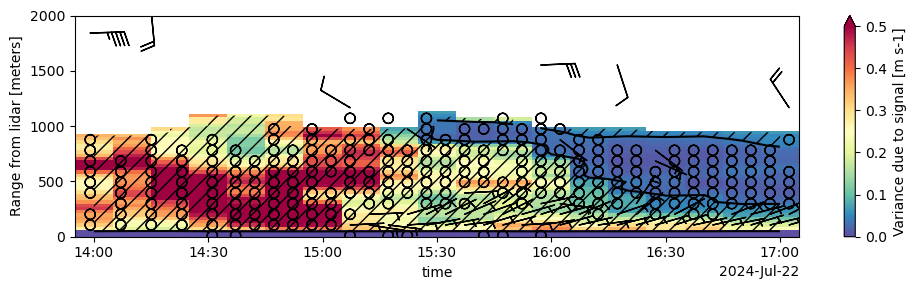

In [262]:
residual_thresh = 0.75
plot_every = 5
plt.figure(figsize=(10, 3))
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T14:00:00', '2024-07-22T17:00:00')).T.plot(cmap='Spectral_r', vmin=0, vmax=0.5)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T14:00:00', '2024-07-22T17:00:00')).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T14:00:00', '2024-07-22T17:00:00')).T.plot.contour(
       levels=[0.04], colors=['k'], add_colorbar=False, label='PBL Tucker method')
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
plt.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every])
plt.ylim([0, 2000])
plt.ylim([0, 2000])
plt.tight_layout()

plt.savefig('Velocity_variance.png', bbox_inches='tight')

In [82]:
mask = vert_profs["wind_speed_error"] < 1
mask = np.logical_and(mask, vert_profs["height"] > 150.)
vert_profs_avg = vert_profs
vert_profs_avg["wind_direction"] = vert_profs_avg["wind_direction"].rolling(height=2).mean()
ds_wind_harr, pbl_heights_lidar_vads = harr_wavelet_transform(
    vert_profs.where(mask), var_name="wind_direction", scale=60.)

2
(125, 75)


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_1992/1946893855.py:7: SyntaxWarning: invalid escape sequence '\s'
  cbar_kwargs={'label': '$\sigma_w$ [$m^{-2}\ s^{-2}]$'})
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contourf(x, y, z, **kwargs)


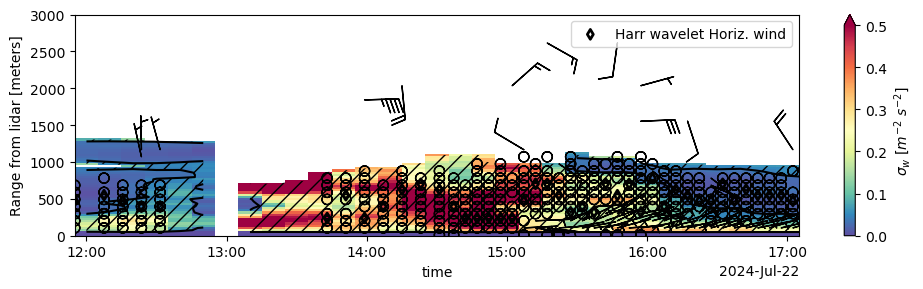

In [47]:
residual_thresh = 0.75
plot_every = 5
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-22T17:00:00')).T.plot(
    cmap='Spectral_r', vmin=0, vmax=0.5, ax=ax,
    cbar_kwargs={'label': '$\sigma_w$ [$m^{-2}\ s^{-2}]$'})
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T17:00:00')).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T12:00:00', '2024-07-23T17:00:00')).T.plot.contour(
       levels=[0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='k', marker='d', facecolors='none', edgecolors='black', linewidth=2, s=25,
        label="Harr wavelet Horiz. wind")
ax.set_ylim([0, 3000])
ax.legend()
fig.tight_layout()

fig.savefig('Velocity_variance.png', bbox_inches='tight')

In [63]:
locations = ["Comer", "Shedd"]
loc = "Shedd"
file_list = sorted(glob.glob('/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/*Comer*.nc'))
pbl_heights_uiuc = xr.open_mfdataset(file_list, )
pbl_heights_uiuc

['/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_0023_ComerYCQC.nc', '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_1200_ComerYCQC.nc', '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_1628_ComerYCQC.nc', '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1607_ComerYCQC.nc', '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1730_ComerYCQC.nc', '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1209_ComerYCQC.nc', '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1909_ComerYCQC.nc']


<xarray.Dataset> Size: 1MB
Dimensions:         (time: 7889, obs: 1)
Coordinates:
  * time            (time) datetime64[ns] 63kB 1969-12-31T23:43:21 ... 1970-0...
    lat             (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
    lon             (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
    gpsalt          (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables: (12/27)
    trajectory      (time) |S1 8kB b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    launch_time     (time) datetime64[ns] 63kB 1969-12-31T23:43:21 ... 1969-1...
    pres            (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
    tdry            (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
    dp              (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
    rh              (time) float32 32kB dask.array<chunksize=(7889,), meta=np.ndarray>
    ...              ...
    reference_rh    (time, obs) float32 32kB dask.array<chunksize=(7889, 1), meta=np.ndarray>
    reference_wspd  (time, obs) float32 32kB dask.array<chunksize=(7889, 1), meta=np.ndarray>
    reference_wdir  (time, obs) float32 32kB dask.array<chunksize=(7889, 1), meta=np.ndarray>
    reference_lat   (time, obs) float32 32kB dask.array<chunksize=(7889, 1), meta=np.ndarray>
    reference_lon   (time, obs) float32 32kB dask.array<chunksize=(7889, 1), meta=np.ndarray>
    reference_alt   (time, obs) float32 32kB dask.array<chunksize=(7889, 1), meta=np.ndarray>
Attributes: (12/92)
    Conventions:            CF-1.6
    RepoRevision:           V4.0.3
    RepoLastChangedDate:    Fri Jul 26 07:44:35 2024 -0600
    RepoId:                 65dfb63f5d4a9b50ff8e64bae2d6296ac25ab232
    RepoBranch:             ventura-build
    featureType:            trajectory
    ...                     ...
    WindQCDev:              3
    WindQCWL:               10
    WindSats:               4
    WindSmoothWL:           40
    WindVVPresWL:           5
    WindVVdelta:            2.5

In [120]:
pbl_heights = xr.open_mfdataset('/Users/rjackson/khum-soundings-with-pbl.nc')
pbl_heights

<xarray.Dataset> Size: 16MB
Dimensions:                      (time: 24867, atm_pres_ss: 661, launch_time: 7)
Coordinates:
  * time                         (time) datetime64[ns] 199kB 2024-07-22T12:00...
  * atm_pres_ss                  (atm_pres_ss) float64 5kB 100.0 105.0 ... 996.2
  * launch_time                  (launch_time) datetime64[ns] 56B 2024-07-22T...
    index                        (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
Data variables: (12/17)
    HeightMSL                    (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    P                            (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    tdry                         (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    Dewp                         (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    RH                           (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    Speed                        (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    ...                           ...
    pblht_liu_liang              (launch_time) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>
    pblht_regime_liu_liang       (launch_time) <U3 84B dask.array<chunksize=(7,), meta=np.ndarray>
    potential_temperature_ss     (launch_time, atm_pres_ss) float64 37kB dask.array<chunksize=(7, 661), meta=np.ndarray>
    alt_ss                       (launch_time, atm_pres_ss) float64 37kB dask.array<chunksize=(7, 661), meta=np.ndarray>
    pblht_liu_liang_stable_cond  (launch_time) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>
    pblht_liu_liang_shear_cond   (launch_time) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>

<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_83343/2443759971.py:22: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('T [$^{\circ}C$]')
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


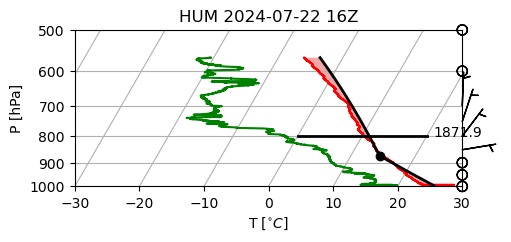

In [23]:
# Set up plot
launch_time = 1
sonde = pbl_heights.isel(launch_time=launch_time)
sonde["Dir"].attrs["units"] = "degree"
sonde["Dewp"].attrs["units"] = "degC"
sonde["P"] = sonde["P"].rolling(time=5).mean()
sonde["P"].attrs["units"] = "hPa"
sonde = sonde.dropna(dim="time")
skewt = act.plotting.SkewTDisplay(sonde, figsize=(5, 10))
pblht_liu_liang = sonde["pblht_liu_liang"].values
index = np.argmin(np.abs(sonde["alt"].values - pblht_liu_liang))
pbl_pres = sonde["P"].isel(time=index)
# Add data
skewt.plot_from_spd_and_dir("Speed", "Dir", "P", "tdry", "Dewp")
time_str = sonde.launch_time.dt.strftime('%Y-%m-%d %HZ').values
plt.title(f'HUM {time_str}')
plt.ylim([1000, 500])
plt.xlim([-30, 30])
skewt.axes[0].plot([0, 20], [pbl_pres, pbl_pres], linewidth=2, color='k')
skewt.axes[0].text(21, pbl_pres.values, "%4.1f" % pblht_liu_liang)
plt.ylabel('P [hPa]')
plt.xlabel('T [$^{\circ}C$]')
plt.savefig(f'Hum_sonde{launch_time}.png', bbox_inches='tight')

In [119]:
file_list_comer = sorted(glob.glob('/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/*Comer*.nc'))
file_list_shedd = sorted(glob.glob('/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/*Shedd*.nc'))
file_list_shedd

['/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1320_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1603_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1730_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240722_1900_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_0027_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_1200_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_1600_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240723_2239_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240727_1200_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240727_1559_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240727_1730_SheddAQQC.nc',
 '/Users/rjackson/Downloads/UIUC_SONDE_QC_V1/netcdf/20240727_1902_SheddAQQC.nc',
 '/Users/rjackson/Downloads/

In [335]:
sonde

<xarray.Dataset> Size: 3MB
Dimensions:                      (time: 24867, atm_pres_ss: 661)
Coordinates:
  * time                         (time) datetime64[ns] 199kB 2024-07-22T12:00...
  * atm_pres_ss                  (atm_pres_ss) float64 5kB 100.0 105.0 ... 996.2
    launch_time                  datetime64[ns] 8B 2024-07-23T00:30:01
    index                        (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
Data variables: (12/17)
    HeightMSL                    (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
    P                            (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
    tdry                         (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
    Dewp                         (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
    RH                           (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
    Speed                        (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
    ...                           ...
    pblht_liu_liang              float64 8B dask.array<chunksize=(), meta=np.ndarray>
    pblht_regime_liu_liang       <U3 12B dask.array<chunksize=(), meta=np.ndarray>
    potential_temperature_ss     (atm_pres_ss) float64 5kB dask.array<chunksize=(661,), meta=np.ndarray>
    alt_ss                       (atm_pres_ss) float64 5kB dask.array<chunksize=(661,), meta=np.ndarray>
    pblht_liu_liang_stable_cond  float64 8B dask.array<chunksize=(), meta=np.ndarray>
    pblht_liu_liang_shear_cond   float64 8B dask.array<chunksize=(), meta=np.ndarray>

2024-07-22T16:00:01.000000000
2024-07-22T17:30:01.000000000


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff

2024-07-22T19:00:01.000000000
2024-07-23T00:30:01.000000000


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)


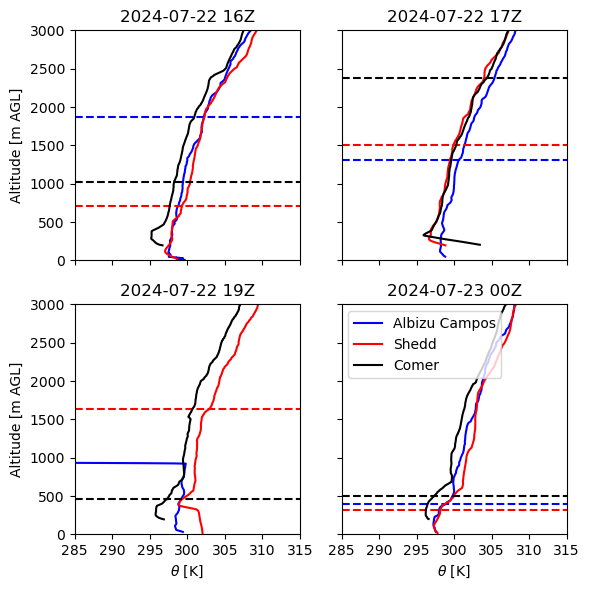

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
limit = [285, 315]
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    print(pbl_heights["launch_time"][launch_time].values)
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    
    theta = potential_temperature(sonde["P"], sonde["tdry"].rolling(time=10).mean())
    lapse_rate = sonde["tdry"] / sonde["alt"] * 1e-3
    ax[int(j/2), j%2].plot(theta.values[:], sonde["alt"].values[:], label="Albizu Campos", color='b')
    ax[int(j/2), j%2].plot(limit, [sonde["pblht_liu_liang"].values, sonde["pblht_liu_liang"].values], color='b', linestyle='--')
    height = sonde["alt"]
    shedd = xr.open_dataset(file_list_shedd[i])
    lapse_rate = shedd["tdry"].diff(dim="time") / (shedd["alt"].diff(dim="time") * 1e-3)
    shedd = shedd.where(lapse_rate > -100, drop=True)
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    
    ax[int(j/2), j%2].plot(shedd["theta"].values[:], shedd["alt"].values[:], label="Shedd", color='r')
    ax[int(j/2), j%2].plot(limit, [shedd["pblht_liu_liang"].values, shedd["pblht_liu_liang"].values],
                           color='r', linestyle='--')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    lapse_rate = comer["tdry"].diff(dim="time") / (comer["alt"].diff(dim="time") * 1e-3)
    comer = comer.where(lapse_rate > -100, drop=True)
    comer = act.retrievals.calculate_pbl_liu_liang(comer)
    ax[int(j/2), j%2].plot(comer["theta"].values[:], comer["alt"].values[:], label="Comer", color='k')
    ax[int(j/2), j%2].plot(limit, [comer["pblht_liu_liang"].values, comer["pblht_liu_liang"].values],
                           color='k', linestyle='--')
    comer.close()
    
    #for k in range(len(unstable)):
    #    if unstable[k]:
    #        ax[j].fill_between(
    #            [305, 345],
    #            [height[k], height[k]],
    #            [height[k+1], height[k+1]], color='k', alpha=0.2, edgecolor=None)
    #ax2.plot(dtheta_dz, sonde["alt"].values, color='r')
    #ax[i].scatter(thetae.values[pbls[0]], sonde["alt"].values[pbls[0]], label="Layer heights")
    
    ax[int(j/2), j%2].set_ylim([0, 3000])
    #ax2.set_ylim([0, 3000])
    ax[int(j/2), j%2].set_xlim(limit)
    ax[int(j/2), j%2].set_xticks([285, 290, 295, 300, 305, 310, 315])
    #ax2.set_xlim([-300, 300])
    if int(j/2) == 1:
        ax[int(j/2), j%2].set_xlabel("$\\theta$ [K]")
    if j % 2 == 0:
        ax[int(j/2), j%2].set_ylabel("Altitude [m AGL]")
    if j % 2 == 1:
        ax[int(j/2), j%2].set_yticklabels([])
    if int(j/2) == 0:
        ax[int(j/2), j%2].set_xticklabels([])
    ax[int(j/2), j%2].set_title(sonde.launch_time.dt.strftime("%Y-%m-%d %HZ").values)
    
    #plt.gca().invert_yaxis()
ax[1, 1].legend()
fig.tight_layout()
fig.savefig('Theta_profiles.png', bbox_inches='tight')

2024-07-22T16:00:01.000000000


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)


2024-07-22T17:30:01.000000000


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)


2024-07-22T19:00:01.000000000
2024-07-23T00:30:01.000000000


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:292: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/act/retrievals/sonde.py:302: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)


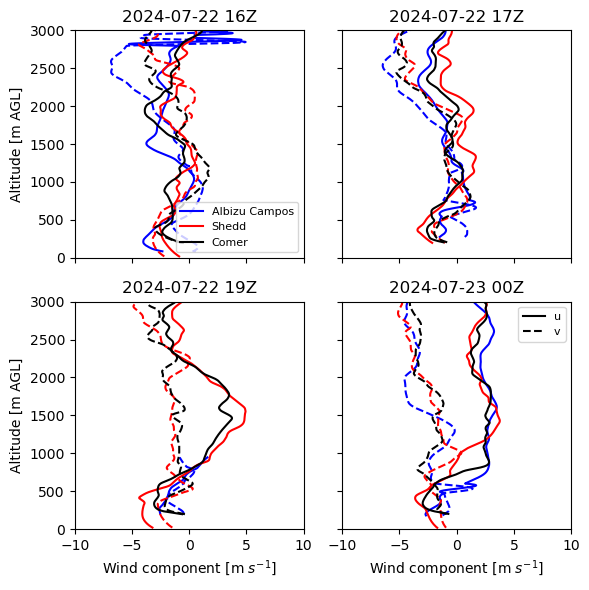

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
limit = [-10, 10]
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    print(pbl_heights["launch_time"][launch_time].values)
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    
    u, v = wind_components(sonde["Speed"].rolling(time=60).mean(), np.deg2rad(sonde["Dir"].rolling(time=60).mean()))
    dtheta_dz = np.gradient(theta.rolling(time=10).mean(), sonde["alt"].values/1e3)
    lapse_rate = sonde["tdry"] / sonde["alt"] * 1e-3
    
    unstable = dtheta_dz < -1
    #ax2 = ax[i].twiny()
    if j == 0:
        ax[int(j/2), j%2].plot(u, sonde["alt"].values[:], color='b', label="Albizu Campos")
    else:
        ax[int(j/2), j%2].plot(u, sonde["alt"].values[:], color='b')
        
    ax[int(j/2), j%2].plot(v, sonde["alt"].values[:], color='b', linestyle='--')
    #ax[int(j/2), j%2].plot(limit, [sonde["pblht_liu_liang"].values, sonde["pblht_liu_liang"].values], color='b', linestyle='--')
    height = sonde["alt"]
    shedd = xr.open_dataset(file_list_shedd[i])
    lapse_rate = shedd["tdry"].diff(dim="time") / (shedd["alt"].diff(dim="time") * 1e-3)
    shedd = shedd.where(lapse_rate > -100, drop=True)
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    if j == 0:
        ax[int(j/2), j%2].plot(shedd["u_wind"], shedd["alt"].values[:], color='r', label="Shedd")
    else:
        ax[int(j/2), j%2].plot(shedd["u_wind"], shedd["alt"].values[:], color='r')
    ax[int(j/2), j%2].plot(shedd["v_wind"], shedd["alt"].values[:], color='r', linestyle='--')
    #ax[int(j/2), j%2].plot(limit, [shedd["pblht_liu_liang"].values, shedd["pblht_liu_liang"].values],
    #                       color='r', linestyle='--')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    lapse_rate = comer["tdry"].diff(dim="time") / (comer["alt"].diff(dim="time") * 1e-3)
    comer = comer.where(lapse_rate > -100, drop=True)
    comer = act.retrievals.calculate_pbl_liu_liang(comer)
    if j == 0:
        ax[int(j/2), j%2].plot(comer["u_wind"], comer["alt"].values[:], label="Comer", color='k')
        ax[int(j/2), j%2].plot(comer["v_wind"], comer["alt"].values[:], color='k', linestyle='--')
    elif j == 3:
        ax[int(j/2), j%2].plot(comer["u_wind"], comer["alt"].values[:], label="u", color='k')
        ax[int(j/2), j%2].plot(comer["v_wind"], comer["alt"].values[:], label="v", color='k', linestyle='--')
    else:
        ax[int(j/2), j%2].plot(comer["u_wind"], comer["alt"].values[:], color='k')
        ax[int(j/2), j%2].plot(comer["v_wind"], comer["alt"].values[:], color='k', linestyle='--')
    
    #ax[int(j/2), j%2].plot(limit, [comer["pblht_liu_liang"].values, comer["pblht_liu_liang"].values],
    #                       color='k', linestyle='--')
    comer.close()
    ax[int(j/2), j%2].set_ylim([0, 3000])
    #ax2.set_ylim([0, 3000])
    ax[int(j/2), j%2].set_xlim(limit)
    ax[int(j/2), j%2].set_xticks([-10, -5, 0, 5, 10])
    #ax2.set_xlim([-300, 300])
    if int(j/2) == 1:
        ax[int(j/2), j%2].set_xlabel("Wind component [m $s^{-1}$]")
    if j % 2 == 0:
        ax[int(j/2), j%2].set_ylabel("Altitude [m AGL]")
    if j % 2 == 1:
        ax[int(j/2), j%2].set_yticklabels([])
    if int(j/2) == 0:
        ax[int(j/2), j%2].set_xticklabels([])
    ax[int(j/2), j%2].set_title(sonde.launch_time.dt.strftime("%Y-%m-%d %HZ").values)
    
    #plt.gca().invert_yaxis()
ax[1, 1].legend(fontsize=8)
ax[0, 0].legend(loc="lower right", fontsize=8)
fig.tight_layout()
fig.savefig('wind_profiles.png', bbox_inches='tight')

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_83377/1846657403.py:1: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  u, v = wind_components(sonde["Speed"].values * units.knots, sonde["Dir"].values)


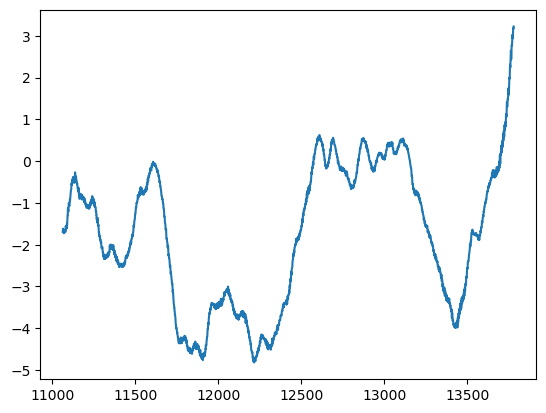

In [45]:
u, v = wind_components(sonde["Speed"].values * units.knots, sonde["Dir"].values)
u = u.to("m/s")
v = v.to("m/s")
plt.plot(-np.cos(sonde["Dir"].values) *

2024-07-22T16:00:01.000000000
2024-07-22T17:30:01.000000000
2024-07-22T19:00:01.000000000
2024-07-23T00:30:01.000000000


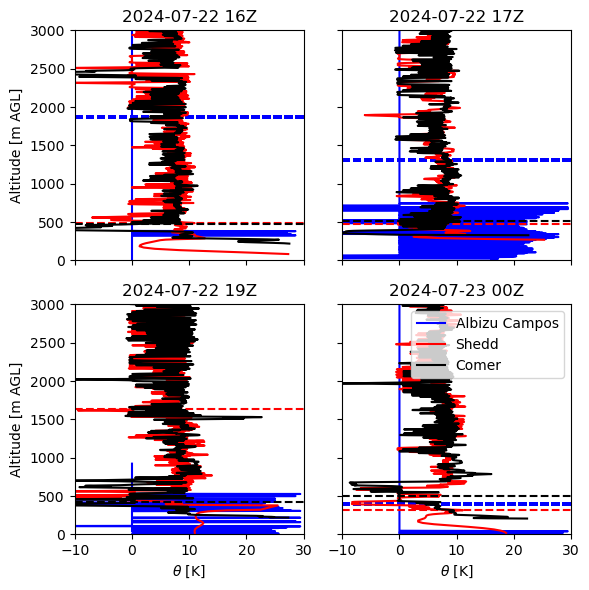

In [372]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
limit = [-10, 30]
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    print(pbl_heights["launch_time"][launch_time].values)
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    
    theta = potential_temperature(sonde["P"], sonde["tdry"].rolling(time=10).mean())
    dtheta_dz = np.gradient(theta.rolling(time=10).mean(), sonde["alt"].values/1e3)
    lapse_rate = sonde["tdry"].diff(dim="time") / (sonde["alt"].diff(dim="time") * 1e-3)
    sonde = sonde.where(np.abs(lapse_rate.compute()) < 30, drop=True)
    lapse_rate = lapse_rate.where(np.abs(lapse_rate.compute()) < 30, drop=True)
    unstable = dtheta_dz < -1
    #ax2 = ax[i].twiny()
    ax[int(j/2), j%2].plot(-lapse_rate.values[:], sonde["alt"].values[:], label="Albizu Campos", color='b')
    ax[int(j/2), j%2].plot(limit, [sonde["pblht_liu_liang"].values, 
                                   sonde["pblht_liu_liang"].values], color='b', linestyle='--')
    height = sonde["alt"]
    shedd = xr.open_dataset(file_list_shedd[i])
    lapse_rate = shedd["tdry"].diff(dim="time") / (shedd["alt"].diff(dim="time") * 1e-3)
    shedd = shedd.where(np.abs(lapse_rate) < 30, drop=True)
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    lapse_rate = lapse_rate.where(np.abs(lapse_rate.compute()) < 30, drop=True)
    ax[int(j/2), j%2].plot(-lapse_rate.values[:], shedd["alt"].values[:], label="Shedd", color='r')
    ax[int(j/2), j%2].plot(limit, [shedd["pblht_liu_liang"].values, shedd["pblht_liu_liang"].values],
                           color='r', linestyle='--')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    lapse_rate = comer["tdry"].diff(dim="time") / (comer["alt"].diff(dim="time") * 1e-3)
    comer = comer.where(np.abs(lapse_rate) < 30, drop=True)
    comer = act.retrievals.calculate_pbl_liu_liang(comer)
    lapse_rate = lapse_rate.where(np.abs(lapse_rate.compute()) < 30, drop=True)
    ax[int(j/2), j%2].plot(-lapse_rate.values[:], comer["alt"].values[:], label="Comer", color='k')
    ax[int(j/2), j%2].plot(limit, [comer["pblht_liu_liang"].values, comer["pblht_liu_liang"].values],
                           color='k', linestyle='--')
    comer.close()
    
    ax[int(j/2), j%2].set_ylim([0, 3000])
    #ax2.set_ylim([0, 3000])
    ax[int(j/2), j%2].set_xlim(limit)
    #ax[int(j/2), j%2].set_xticks([285, 290, 295, 300, 305, 310, 315])
    #ax2.set_xlim([-300, 300])
    if int(j/2) == 1:
        ax[int(j/2), j%2].set_xlabel("$\\theta$ [K]")
    if j % 2 == 0:
        ax[int(j/2), j%2].set_ylabel("Altitude [m AGL]")
    if j % 2 == 1:
        ax[int(j/2), j%2].set_yticklabels([])
    if int(j/2) == 0:
        ax[int(j/2), j%2].set_xticklabels([])
    ax[int(j/2), j%2].set_title(sonde.launch_time.dt.strftime("%Y-%m-%d %HZ").values)
    
    #plt.gca().invert_yaxis()
ax[1, 1].legend()
fig.tight_layout()
fig.savefig('lapse_rates.png', bbox_inches='tight')

2024-07-22T16:00:01.000000000
2024-07-22T17:30:01.000000000
2024-07-22T19:00:01.000000000
2024-07-23T00:30:01.000000000


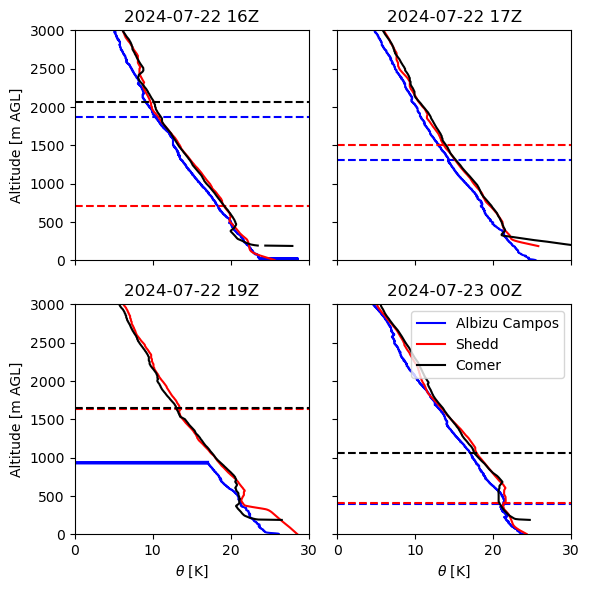

In [345]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
limit = [0, 30]
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    print(pbl_heights["launch_time"][launch_time].values)
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    lapse_rate = sonde["tdry"] / sonde["alt"] * 1e-3
    theta = potential_temperature(sonde["P"], sonde["tdry"].where(lapse_rate > -10))
    dtheta_dz = np.gradient(sonde["tdry"].rolling(time=10).mean(), sonde["alt"].values/1e3)
    unstable = dtheta_dz < -1
    #ax2 = ax[i].twiny()
    ax[int(j/2), j%2].plot(sonde["tdry"].values[:], sonde["alt"].values[:], label="Albizu Campos", color='b')
    ax[int(j/2), j%2].plot(limit, [sonde["pblht_liu_liang"].values, sonde["pblht_liu_liang"].values], color='b', linestyle='--')
    height = sonde["alt"]
    shedd = xr.open_dataset(file_list_shedd[i])
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    ax[int(j/2), j%2].plot(shedd["tdry"].values[:], shedd["alt"].values[:], label="Shedd", color='r')
    ax[int(j/2), j%2].plot(limit, [shedd["pblht_liu_liang"].values, shedd["pblht_liu_liang"].values], color='r', linestyle='--')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    comer= act.retrievals.calculate_pbl_liu_liang(comer)
    ax[int(j/2), j%2].plot(comer["tdry"].values[:], comer["alt"].values[:], label="Comer", color='k')
    ax[int(j/2), j%2].plot(limit, [comer["pblht_liu_liang"].values, comer["pblht_liu_liang"].values], color='k', linestyle='--')
    comer.close()
    
    #for k in range(len(unstable)):
    #    if unstable[k]:
    #        ax[j].fill_between(
    #            [305, 345],
    #            [height[k], height[k]],
    #            [height[k+1], height[k+1]], color='k', alpha=0.2, edgecolor=None)
    #ax2.plot(dtheta_dz, sonde["alt"].values, color='r')
    #ax[i].scatter(thetae.values[pbls[0]], sonde["alt"].values[pbls[0]], label="Layer heights")
    
    ax[int(j/2), j%2].set_ylim([0, 3000])
    #ax2.set_ylim([0, 3000])
    ax[int(j/2), j%2].set_xlim(limit)
    #ax[int(j/2), j%2].set_xticks([285, 290, 295, 300, 305, 310, 315])
    #ax2.set_xlim([-300, 300])
    if int(j/2) == 1:
        ax[int(j/2), j%2].set_xlabel("$\\theta$ [K]")
    if j % 2 == 0:
        ax[int(j/2), j%2].set_ylabel("Altitude [m AGL]")
    if j % 2 == 1:
        ax[int(j/2), j%2].set_yticklabels([])
    if int(j/2) == 0:
        ax[int(j/2), j%2].set_xticklabels([])
    ax[int(j/2), j%2].set_title(sonde.launch_time.dt.strftime("%Y-%m-%d %HZ").values)
    
    #plt.gca().invert_yaxis()
ax[1, 1].legend()
fig.tight_layout()
fig.savefig('Temp_profiles.png', bbox_inches='tight')

In [63]:
sonde = pbl_heights.isel(launch_time=0)
sonde["P"].rolling(time=5).mean().dropna(dim='time').values[0:1000]

NameError: name 'pbl_heights' is not defined

In [41]:
hsrl = xr.open_dataset('/Users/rjackson/Downloads/gvhsrl_day_20240722T0000_20240723T0000_30s_30m.nc')
hsrl = hsrl.set_coords(["altitude", "height", "time"])
#hsrl = hsrl.sel(time=slice("2024-07-22T15:30:00", "2024-07-23T00:00:00"))

<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/3443532724.py:5: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contourf(x, y, z, **kwargs)
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/3443532724.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/3443532724.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('hsrl_with_estimates.png', bbox_inches='tight')


(0.0, 3000.0)

/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


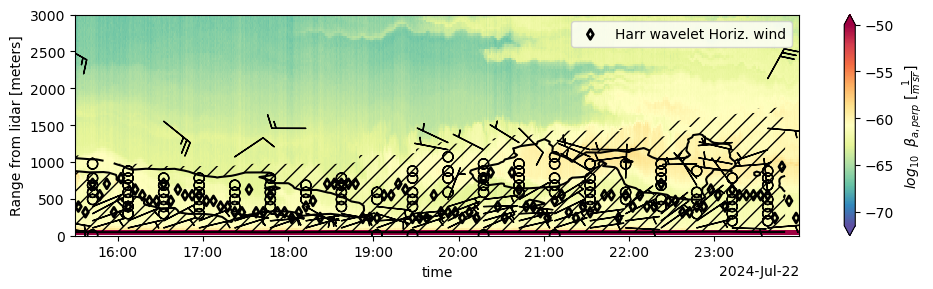

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
(10*np.log10(hsrl["atten_beta_a_backscat"])).sel(time=slice('2024-07-22T15:30:00',
                                                               '2024-07-23T00:00:00')).T.plot(
    vmax=-65, cmap='Spectral_r', vmin=-50,
    cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
    y="height")
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T14:00:00', '2024-07-23T17:00:00')).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice('2024-07-22T14:00:00', '2024-07-23T17:00:00')).T.plot.contour(
       levels=[0, 0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::plot_every, ::plot_every], 
          y[::plot_every, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='k', marker='d', facecolors='none', edgecolors='black', linewidth=2, s=25,
        label="Harr wavelet Horiz. wind")
ax.set_ylim([0, 2000])
ax.legend()
fig.tight_layout()
fig.savefig('hsrl_with_estimates.png', bbox_inches='tight')
plt.ylim([0, 3000])

In [50]:
hsrl["log_beta_a_backscat"] = np.log10(hsrl["atten_beta_a_backscat"].where(hsrl["altitude"] < 3000.)).rolling(time=6).mean()
hsrl_harr, hsrl_pbl_heights = harr_wavelet_transform(
    hsrl, var_name="log_beta_a_backscat", scale=60.)

1
(1298, 251)


In [24]:
def rolling_average(var, window):
    kernel = 1/window * np.ones((window, ))
    return np.convolve(var, kernel, mode='same') 

<>:7: SyntaxWarning: invalid escape sequence '\ '
<>:7: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_83343/851688506.py:7: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contourf(x, y, z, **kwargs)


(0.0, 3000.0)

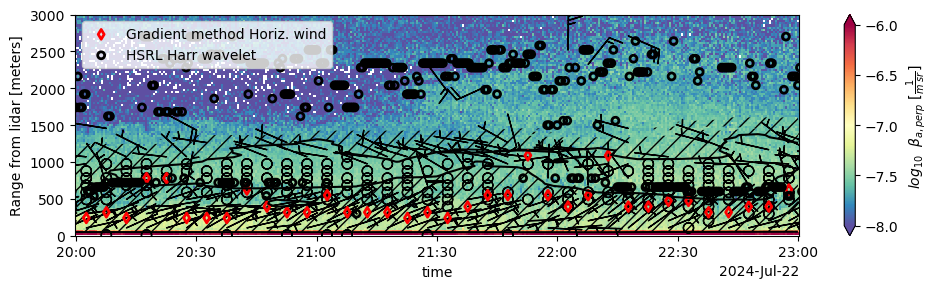

In [274]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
start_time = '2024-07-22T20:00:00'
end_time = '2024-07-22T23:00:00'
np.log10(hsrl["atten_beta_a_backscat"]).sel(time=slice(start_time,
                                                               end_time)).T.plot(
    vmax=-6, cmap='Spectral_r', vmin=-8,
    cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
    y="height")
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contour(
       levels=[0, 0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='r', marker='d', facecolors='none', edgecolors='red', linewidth=2, s=25,
        label="Gradient method Horiz. wind")
ax.scatter(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', marker='o', facecolors='none', edgecolors='black', linewidth=2, s=25,
        label="HSRL Harr wavelet")
ax.set_ylim([0, 3000])
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig('hsrl_with_estimates3to6.png', bbox_inches='tight')
plt.ylim([0, 3000])

In [53]:
depol_enh = pd.read_csv('/Users/rjackson/Downloads/PBLH_methods_CL61_NEIU_20240722.txt', sep='\t')
depol_enh["time"] = np.array([np.datetime64(f'2024-07-22T{x}') for x in depol_enh["Hour_Minute_Second"]])
depol_enh = depol_enh.set_index('time')
depol_enh

Hour_Minute_Second  PBLH_Gradient(km)  \
time                                                        
2024-07-22 00:03:06           00:03:06             2.2752   
2024-07-22 00:08:06           00:08:06             2.3808   
2024-07-22 00:13:05           00:13:05             2.6256   
2024-07-22 00:18:05           00:18:05             2.6016   
2024-07-22 00:23:06           00:23:06             2.1360   
...                                ...                ...   
2024-07-22 23:38:05           23:38:05             3.2688   
2024-07-22 23:43:05           23:43:05             3.3552   
2024-07-22 23:48:05           23:48:05             3.1728   
2024-07-22 23:53:05           23:53:05             3.1632   
2024-07-22 23:58:05           23:58:05             3.2304   

                     PBLH_Depol_Enhanced(km)  
time                                          
2024-07-22 00:03:06                   1.5264  
2024-07-22 00:08:06                   1.6560  
2024-07-22 00:13:05                   1.6992  
2024-07-22 00:18:05                   1.6176  
2024-07-22 00:23:06                   1.7328  
...                                      ...  
2024-07-22 23:38:05                   1.7184  
2024-07-22 23:43:05                   2.1744  
2024-07-22 23:48:05                   1.8480  
2024-07-22 23:53:05                   1.9008  
2024-07-22 23:58:05                   1.8048  

[288 rows x 3 columns]

In [62]:
times_wrf_pbl = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='1h')[:-1]

boulac_pbl = pd.read_excel('/Users/rjackson/Downloads/WRF_BouLac_Lidar.xlsx', sheet_name="pblh", header=None)
boulac_pbl_ctrl = np.mean(boulac_pbl.values[:, 0:5], axis=1)
boulac_pbl_crocus = np.mean(boulac_pbl.values[:, 5:10], axis=1)

In [276]:
pbl_heights

<xarray.Dataset> Size: 16MB
Dimensions:                      (time: 24867, atm_pres_ss: 661, launch_time: 7)
Coordinates:
  * time                         (time) datetime64[ns] 199kB 2024-07-22T12:00...
  * atm_pres_ss                  (atm_pres_ss) float64 5kB 100.0 105.0 ... 996.2
  * launch_time                  (launch_time) datetime64[ns] 56B 2024-07-22T...
    index                        (time) float64 199kB dask.array<chunksize=(24867,), meta=np.ndarray>
Data variables: (12/17)
    HeightMSL                    (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    P                            (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    tdry                         (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    Dewp                         (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    RH                           (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    Speed                        (launch_time, time) float64 1MB dask.array<chunksize=(7, 24867), meta=np.ndarray>
    ...                           ...
    pblht_liu_liang              (launch_time) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>
    pblht_regime_liu_liang       (launch_time) <U3 84B dask.array<chunksize=(7,), meta=np.ndarray>
    potential_temperature_ss     (launch_time, atm_pres_ss) float64 37kB dask.array<chunksize=(7, 661), meta=np.ndarray>
    alt_ss                       (launch_time, atm_pres_ss) float64 37kB dask.array<chunksize=(7, 661), meta=np.ndarray>
    pblht_liu_liang_stable_cond  (launch_time) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>
    pblht_liu_liang_shear_cond   (launch_time) float64 56B dask.array<chunksize=(7,), meta=np.ndarray>

<>:14: SyntaxWarning: invalid escape sequence '\ '
<>:14: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_49306/4138731426.py:14: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contourf(x, y, z, **kwargs)


2024-07-22T15:00:01.000000000


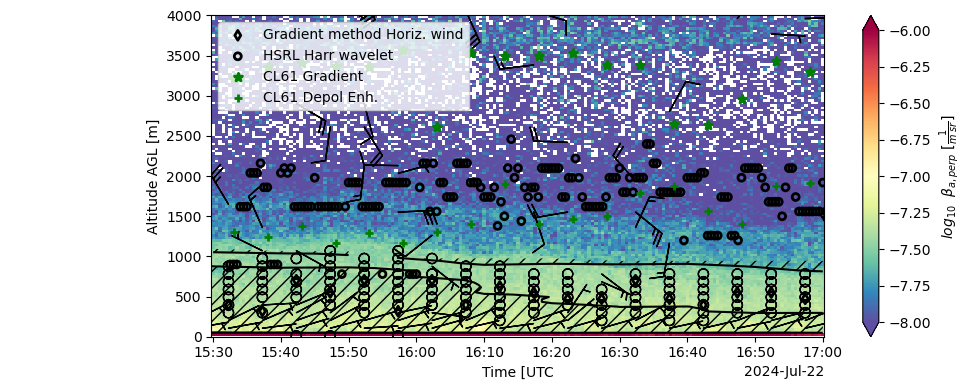

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
start_time = '2024-07-22T14:00:00'
end_time = '2024-07-22T17:00:00'
if end_time == '2024-07-23T00:00:00':
    end_time_sonde = '2024-07-23T01:00:00'
else:
    end_time_sonde = end_time
offset = 1
which_sonde = pbl_heights["launch_time"].sel(launch_time=slice(start_time, end_time_sonde))
pblht_liu_liang = pbl_heights["pblht_liu_liang"].sel(launch_time=which_sonde)
np.log10(hsrl["beta_a_backscat_perpendicular"]).sel(time=slice(start_time,
                                                               end_time)).T.plot(
    vmax=-6, cmap='Spectral_r', vmin=-8,
    cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
    y="height")
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contour(
       levels=[0, 0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='r', marker='d', facecolors='none', edgecolors='black', linewidth=2, s=25,
        label="Gradient method Horiz. wind")
ax.scatter(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', marker='o', facecolors='none', edgecolors='black', linewidth=2, s=25,
        label="HSRL Harr wavelet")
#ax.scatter(times_wrf_pbl, boulac_pbl_ctrl, label="CTRL", color='r', linewidth=2, s=49, marker='+')
#ax.scatter(times_wrf_pbl, boulac_pbl_crocus, label="CROCUS", color='r', linewidth=2, s=25, marker='o')
ax.scatter(depol_enh.index.values, depol_enh["PBLH_Gradient(km)"].values*1e3, color='g', linewidth=2, marker='*',
          label="CL61 Gradient")
ax.scatter(depol_enh.index.values, depol_enh["PBLH_Depol_Enhanced(km)"].values*1e3, color='g', linewidth=2, marker='+',
          label="CL61 Depol Enh.")
print(which_sonde.values[0] - np.timedelta64(offset, 'h'))
ax.text(which_sonde.values[0] - np.timedelta64(offset, 'h'), pblht_liu_liang.values[0], 
        str(np.round(pblht_liu_liang.values[0], 1)), fontweight='bold', fontsize=12.,
       color='w')
ax.set_xlabel('Time [UTC')
ax.set_ylabel('Altitude AGL [m]')
ax.set_ylim([0, 4000])
ax.legend(loc="upper left")
#ax.set_title('BouLac Model run')
fig.tight_layout()
fig.savefig('hsrl_with_estimates_9to12.png', bbox_inches='tight')

In [31]:
times_wrf_pbl = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='30min')[:]
times_wrf_pbl_hr = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='1h')[:]
myj_pbl = pd.read_excel('/Users/rjackson/Downloads/WRF_MYJ_Lidar.xlsx', sheet_name="pblh_lidar_loc_MYJ", header=None)
myj_pbl_ctrl = np.mean(myj_pbl.values[:, 1:6], axis=1)
myj_pbl_crocus = np.mean(myj_pbl.values[:, 6:], axis=1)
myj_u = pd.read_excel('/Users/rjackson/Downloads/WRF_MYJ_Lidar.xlsx', sheet_name="u_lidar_loc_MYJ", header=None)
myj_u_ctrl = np.mean(myj_u.values[:, 1:6], axis=1).reshape((109, 54)).astype(float)
myj_u_crocus = np.mean(myj_u.values[:, 6:], axis=1).reshape((109, 54)).astype(float)
myj_v = pd.read_excel('/Users/rjackson/Downloads/WRF_MYJ_Lidar.xlsx', sheet_name="v_lidar_loc_MYJ", header=None)
myj_v_ctrl = np.mean(myj_v.values[:, 1:6], axis=1).reshape((109, 54)).astype(float)
myj_v_crocus = np.mean(myj_v.values[:, 6:], axis=1).reshape((109, 54)).astype(float)
myj_geohgt = pd.read_excel('/Users/rjackson/Downloads/WRF_MYJ_Lidar.xlsx', sheet_name="geohgt", header=None)
myj_geohgt_ctrl = np.mean(myj_geohgt.values[:, 1:6], axis=1).reshape((55, 54)).astype(float)
myj_geohgt_crocus = np.mean(myj_geohgt.values[:, 6:], axis=1).reshape((55, 54)).astype(float)

In [76]:
times_wrf_pbl = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='30min')[:]
times_wrf_pbl_hr = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='1h')[:]
boulac_pbl = pd.read_excel('/Users/rjackson/Downloads/WRF_BouLac_Lidar.xlsx', sheet_name="pblh", header=None)
boulac_pbl_ctrl = np.mean(boulac_pbl.values[:, 1:6], axis=1)
boulac_pbl_crocus = np.mean(boulac_pbl.values[:, 6:], axis=1)
boulac_u = pd.read_excel('/Users/rjackson/Downloads/WRF_BouLac_Lidar.xlsx', sheet_name="u", header=None)
boulac_u_ctrl = np.mean(boulac_u.values[:, 1:6], axis=1).reshape((55, 54)).astype(float)
boulac_u_crocus = np.mean(boulac_u.values[:, 6:], axis=1).reshape((55, 54)).astype(float)
boulac_v = pd.read_excel('/Users/rjackson/Downloads/WRF_BouLac_Lidar.xlsx', sheet_name="v", header=None)
boulac_v_ctrl = np.mean(boulac_v.values[:, 1:6], axis=1).reshape((55, 54)).astype(float)
boulac_v_crocus = np.mean(boulac_v.values[:, 6:], axis=1).reshape((55, 54)).astype(float)
boulac_geohgt = pd.read_excel('/Users/rjackson/Downloads/WRF_BouLac_Lidar.xlsx', sheet_name="geohgt", header=None)
boulac_geohgt_ctrl = np.mean(boulac_geohgt.values[:, 1:6], axis=1).reshape((55, 54)).astype(float)
boulac_geohgt_crocus = np.mean(boulac_geohgt.values[:, 6:], axis=1).reshape((55, 54)).astype(float)

In [77]:
times_wrf_pbl = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='30min')[:]
times_wrf_pbl_hr = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='1h')[:]
ysu_pbl = pd.read_excel('/Users/rjackson/Downloads/WRF_YSU_Lidar.xlsx', sheet_name="pblh_lidar_loc_YSU", header=None)
ysu_pbl_ctrl = np.mean(ysu_pbl.values[:, 1:6], axis=1)
ysu_pbl_crocus = np.mean(ysu_pbl.values[:, 6:], axis=1)
ysu_u = pd.read_excel('/Users/rjackson/Downloads/WRF_YSU_Lidar.xlsx', sheet_name="u_lidar_loc_YSU", header=None)
ysu_u_ctrl = np.mean(ysu_u.values[:, 1:6], axis=1).reshape((109, 54)).astype(float)
ysu_u_crocus = np.mean(ysu_u.values[:, 6:], axis=1).reshape((109, 54)).astype(float)
ysu_v = pd.read_excel('/Users/rjackson/Downloads/WRF_YSU_Lidar.xlsx', sheet_name="v_lidar_loc_YSU", header=None)
ysu_v_ctrl = np.mean(ysu_v.values[:, 1:6], axis=1).reshape((109, 54)).astype(float)
ysu_v_crocus = np.mean(ysu_v.values[:, 6:], axis=1).reshape((109, 54)).astype(float)
ysu_geohgt = pd.read_excel('/Users/rjackson/Downloads/WRF_YSU_Lidar.xlsx', sheet_name="geohgt", header=None)
ysu_geohgt_ctrl = np.mean(ysu_geohgt.values[:, 1:6], axis=1).reshape((55, 54)).astype(float)
ysu_geohgt_crocus = np.mean(ysu_geohgt.values[:, 6:], axis=1).reshape((55, 54)).astype(float)

In [16]:
vert_profs_hr = vert_profs.resample(time="1h").mean()
vert_profs_hr["u"] = vert_profs_hr["u"].where(vert_profs_hr["wind_speed_error"] < 1)
u_interp = vert_profs_hr["u"].interp(height=msy__geohgt_ctrl.mean(axis=0))
v_interp = vert_profs_hr["v"].interp(height=myj_geohgt_ctrl.mean(axis=0))

(0.0, 3000.0)

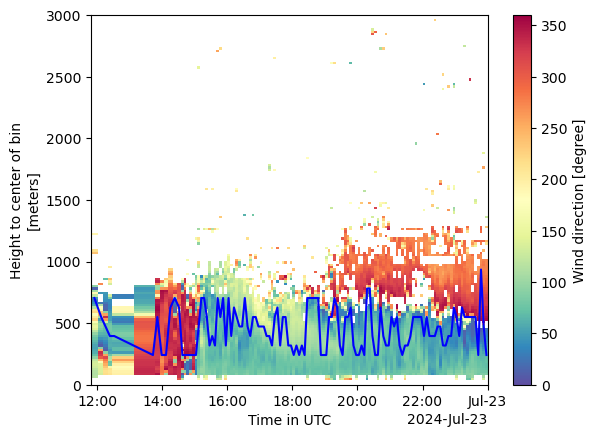

In [58]:
vert_profs["wind_direction"].rolling(height=2).mean().T.plot(zorder=0, vmin=0, vmax=360, cmap="Spectral_r")
plt.plot(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads, color='b', zorder=3)
plt.ylim([0, 3000])

Text(0, 0.5, 'Height [m]')

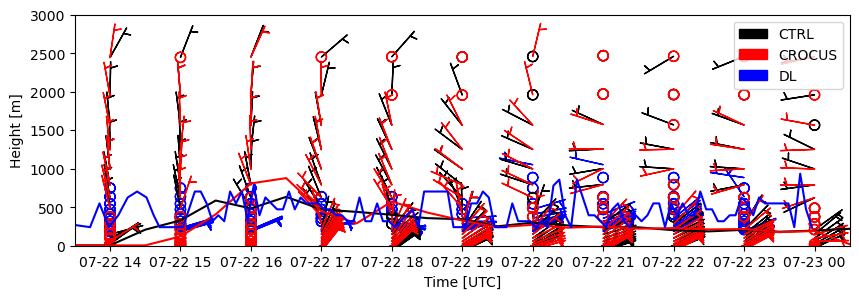

In [46]:
start_time = '2024-07-22T13:30:00'
end_time = '2024-07-23T00:30:00'
plot_every = 5
residual_thresh = 3
mask = vert_profs["wind_speed_error"] < residual_thresh
x = np.tile(times_wrf_pbl_hr, (54, 1)).T
y = myj_geohgt_ctrl - 260.
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.barbs(x[::, ::2], y[::, ::2], myj_u_ctrl[::2, ::2], myj_v_ctrl[::2, ::2], label="CTRL")
ax.barbs(x[::, ::2], y[::, ::2], myj_u_crocus[::2, ::2], myj_v_crocus[::2, ::2], color='r', label="CROCUS")
ax.plot(times_wrf_pbl, myj_pbl_ctrl, color='k')
ax.plot(times_wrf_pbl, myj_pbl_crocus, color='r')
ax.plot(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads, color='b')
#x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
x = np.tile(u_interp["time"], (54, 1)).T
y = np.tile(u_interp["height"], (1, 13))
ax.barbs(x[::, ::2], y[::, ::2], u_interp[::, ::2], v_interp[::, ::2], color='b', label="DL", zorder=0)
ax.set_ylim([0, 3000])
ax.set_xlim([np.datetime64(start_time), np.datetime64(end_time)])
ax.legend()
ax.set_xlabel("Time [UTC]")
#ax.set_xticklabels([f"{x:02d}" for x in [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 00]])
ax.set_ylabel("Height [m]")

In [99]:
myj_geohgt_ctrl.mean(axis=0)[:40]

array([ 185.66213455,  188.67921818,  190.18717455,  191.69436   ,
        193.20192364,  199.23157455,  209.78452727,  220.34239636,
        230.90766909,  242.01035636,  254.23476   ,  267.69659273,
        282.52349455,  298.85656727,  316.85107273,  336.67856   ,
        358.52864727,  382.61174182,  409.16159636,  438.43857091,
        470.73217818,  506.36431636,  545.69209091,  589.1124    ,
        637.06800364,  690.05085455,  748.61068364,  813.36477091,
        885.00467273,  964.30987636, 1052.16196364, 1149.55989091,
       1257.64287273, 1377.71      , 1511.2456    , 1659.96065455,
       1825.86003636, 2011.30090909, 2219.07523636, 2452.54723636])

In [100]:
top_ind = 40
wind_dir_myj = np.rad2deg(np.arctan2(-myj_u_ctrl, -myj_v_ctrl))
wind_dir_ds = xr.Dataset({'wind_direction': (['time', 'height'], wind_dir_myj[::2, :top_ind]),
                          'height': ('height', myj_geohgt_ctrl.mean(axis=0)[:top_ind] - 260.),
                          'time': ('time', times_wrf_pbl_hr)})
ds_wind_harr_myj, pbl_heights_myj_ctrl = harr_wavelet_transform(
    wind_dir_ds, var_name="wind_direction", scale=5.)
wind_dir_myj = np.rad2deg(np.arctan2(-myj_u_crocus, -myj_v_crocus))
wind_dir_ds = xr.Dataset({'wind_direction': (['time', 'height'], wind_dir_myj[::2, :top_ind]),
                          'height': ('height', myj_geohgt_ctrl.mean(axis=0)[:top_ind] - 260.),
                          'time': ('time', times_wrf_pbl_hr)})
ds_wind_harr_myj, pbl_heights_myj_crocus = harr_wavelet_transform(
    wind_dir_ds, var_name="wind_direction", scale=5.)
wind_dir_ysu = np.rad2deg(np.arctan2(-ysu_u_ctrl, -ysu_v_ctrl))
wind_dir_ds = xr.Dataset({'wind_direction': (['time', 'height'], wind_dir_ysu[::2, :top_ind]),
                          'height': ('height', ysu_geohgt_ctrl.mean(axis=0)[:top_ind] - 260.),
                          'time': ('time', times_wrf_pbl_hr)})
ds_wind_harr_ysu, pbl_heights_ysu_ctrl = harr_wavelet_transform(
    wind_dir_ds, var_name="wind_direction", scale=5.)
wind_dir_ysu = np.rad2deg(np.arctan2(-ysu_u_crocus, -ysu_v_crocus))
wind_dir_ds = xr.Dataset({'wind_direction': (['time', 'height'], wind_dir_ysu[::2, :top_ind]),
                          'height': ('height', ysu_geohgt_ctrl.mean(axis=0)[:top_ind] - 260.),
                          'time': ('time', times_wrf_pbl_hr)})
ds_wind_harr_ysu, pbl_heights_ysu_crocus = harr_wavelet_transform(
    wind_dir_ds, var_name="wind_direction", scale=5.)
wind_dir_boulac = np.rad2deg(np.arctan2(-boulac_u_ctrl, -boulac_v_ctrl))
wind_dir_ds = xr.Dataset({'wind_direction': (['time', 'height'], wind_dir_boulac[::, :top_ind]),
                          'height': ('height', boulac_geohgt_ctrl.mean(axis=0)[:top_ind] - 260.),
                          'time': ('time', times_wrf_pbl_hr)})
ds_wind_harr_boulac, pbl_heights_boulac_ctrl = harr_wavelet_transform(
    wind_dir_ds, var_name="wind_direction", scale=5.)
wind_dir_boulac = np.rad2deg(np.arctan2(-boulac_u_crocus, -boulac_v_crocus))
wind_dir_ds = xr.Dataset({'wind_direction': (['time', 'height'], wind_dir_boulac[::, :top_ind]),
                          'height': ('height', boulac_geohgt_ctrl.mean(axis=0)[:top_ind] - 260.),
                          'time': ('time', times_wrf_pbl_hr)})
ds_wind_harr_boulac, pbl_heights_boulac_crocus = harr_wavelet_transform(
    wind_dir_ds, var_name="wind_direction", scale=5.)

0
(55, 40)
0
(55, 40)
0
(55, 40)
0
(55, 40)
0
(55, 40)
0
(55, 40)


<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/3604033813.py:8: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contourf(x, y, z, **kwargs)
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/3604033813.py:8: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),


ValueError: x and y must be the same size

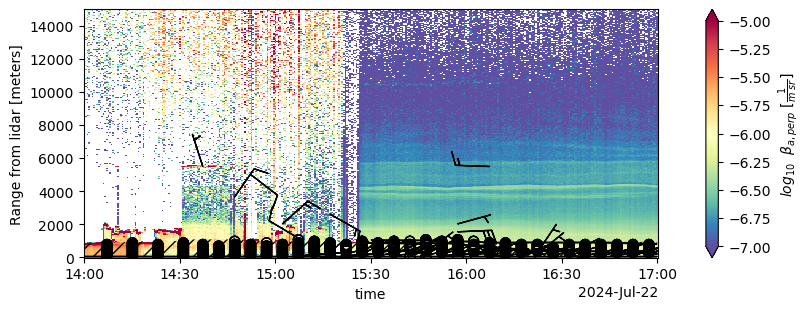

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), layout="constrained")
start_time = '2024-07-22T14:00:00'
end_time = '2024-07-22T17:00:00'
plot_every=5
residual_thresh = 1
np.log10(hsrl["atten_beta_a_backscat"]).sel(time=slice(start_time, end_time)).T.plot(
    vmax=-5, cmap='Spectral_r', vmin=-7,
    cbar_kwargs=dict(label="$log_{10}$  $\\beta_{a,perp}$ [$\\frac{1}{m\ sr}$]"),
    y="height")
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contour(
       levels=[0, 0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].sel(time=slice(start_time, end_time)).values,
                   vert_profs["height"].values, indexing='ij')
ax.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].sel(time=slice(start_time, end_time)).where(vert_profs["wind_speed_error"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].sel(time=slice(start_time, end_time)).where(vert_profs["wind_speed_error"] < residual_thresh)[::, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        edgecolors='black', color='k', linewidth=2, s=49,
        label="Gradient method Horiz. wind")
ax.scatter(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', facecolors='none', edgecolors='black', linewidth=2, s=49,
        label="HSRL Harr wavelet")
ax.scatter(depol_enh.index.values, depol_enh["PBLH_Gradient(km)"].values*1e3, color='y', linewidth=2, marker='*',
          label="CL61 Gradient")
ax.scatter(depol_enh.index.values, depol_enh["PBLH_Depol_Enhanced(km)"].values*1e3, color='y', linewidth=2, marker='+',
          label="CL61 Depol Enh.")
ax.scatter(times_wrf_pbl, myj_pbl_ctrl, label="CTRL", color='r', linewidth=2, s=49, marker='+')
ax.scatter(times_wrf_pbl, myj_pbl_crocus, label="CROCUS", color='r', marker='o')
ax.set_ylim([0, 3000])
ax.legend(loc="upper right", fontsize=8)
ax.set_xlim([np.datetime64(start_time), np.datetime64(end_time)])
ax.set_xlabel('Time [UTC]')
#fig.tight_layout()
fig.savefig('hsrl_with_estimates_myj9to12.png', bbox_inches='tight')

In [56]:
times_wrf_pbl = pd.date_range('2024-07-21T18:00:00', '2024-07-24T00:00:00', freq='30min')[:]

ysu_pbl = pd.read_excel('/Users/rjackson/Downloads/WRF_YSU_Lidar.xlsx', sheet_name="pblh_lidar_loc_YSU", header=None)
ysu_pbl_ctrl = np.mean(ysu_pbl.values[:, 1:6], axis=1)
ysu_pbl_crocus = np.mean(ysu_pbl.values[:, 6:], axis=1)

<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/151544337.py:5: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),


(0.0, 3000.0)

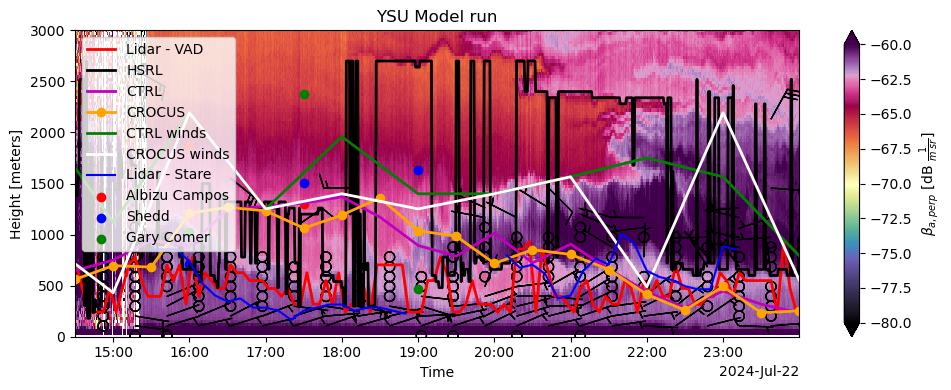

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
(10*np.log10(hsrl["atten_beta_a_backscat"])).sel(time=slice('2024-07-22T14:30:00',
                                                               '2024-07-23T00:00:00')).T.plot(
    vmax=-60, cmap='ChaseSpectral', vmin=-80,
    cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),
    y="height")
#variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
 #   time=slice('2024-07-22T12:00:00', '2024-07-23T00:00:00')).T.plot.contourf(
 #      levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
 #   label='PBL Tucker method', ax=ax)
#variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
#    time=slice('2024-07-22T12:00:00', '2024-07-23T00:00:00')).T.plot.contour(
#       levels=[0, 0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::plot_every, ::plot_every], 
          y[::plot_every, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every])
ax.plot(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='r', linewidth=2, 
        label="Lidar - VAD")
ax.plot(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', linewidth=2,
        label="HSRL")
ax.plot(times_wrf_pbl, ysu_pbl_ctrl, label="CTRL", color='m', linewidth=2, )
ax.plot(times_wrf_pbl, ysu_pbl_crocus, label="CROCUS", color='orange', marker='o', linewidth=2)
ax.plot(times_wrf_pbl_hr, pbl_heights_ysu_ctrl, label="CTRL winds", color='g', linewidth=2)
ax.plot(times_wrf_pbl_hr, pbl_heights_ysu_crocus, label="CROCUS winds", color='w', linewidth=2)
plt.plot(variance_ds['time'].values, pblh_lidar, color='b', label="Lidar - Stare")
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    
    if j == 0:
        ax.scatter(sonde["launch_time"].values, sonde["pblht_liu_liang"].values, color='r', label="Albizu Campos")
    else:
        ax.scatter(sonde["launch_time"].values, sonde["pblht_liu_liang"].values, color='r')
    shedd = xr.open_dataset(file_list_shedd[i])
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    if j == 0:
        ax.scatter(sonde["launch_time"].values, shedd["pblht_liu_liang"].values, color='b', label="Shedd")
    else:
        ax.scatter(sonde["launch_time"].values, shedd["pblht_liu_liang"].values, color='b')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    lapse_rate = comer["tdry"].diff(dim="time") / (comer["alt"].diff(dim="time") * 1e-3)
    comer = comer.where(lapse_rate > -100, drop=True)
    comer = act.retrievals.calculate_pbl_liu_liang(comer)
    if j == 0:
        ax.scatter(sonde["launch_time"].values, comer["pblht_liu_liang"].values, color='g', label="Gary Comer")
    else:
        ax.scatter(sonde["launch_time"].values, comer["pblht_liu_liang"].values, color='g')
    comer.close()
ax.set_ylim([0, 3000])
ax.legend(loc="upper left")
ax.set_title('YSU Model run')
fig.tight_layout()
fig.savefig('hsrl_with_estimates_ysu.png', bbox_inches='tight')
plt.ylim([0, 3000])

<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/772635390.py:5: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),


(0.0, 3000.0)

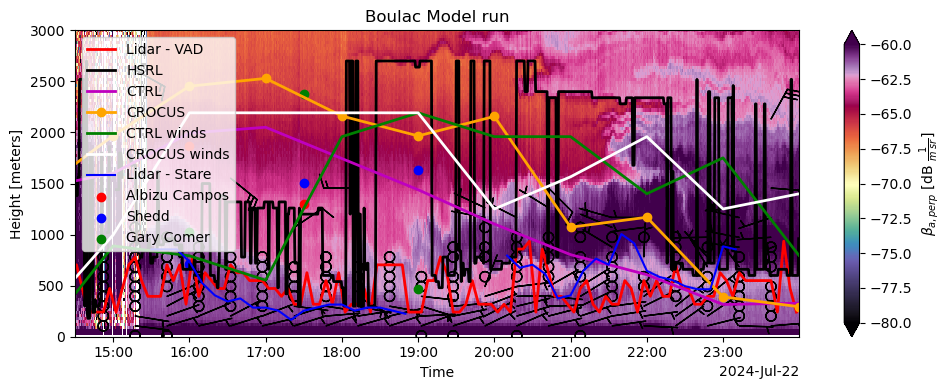

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
(10*np.log10(hsrl["atten_beta_a_backscat"])).sel(time=slice('2024-07-22T14:30:00',
                                                               '2024-07-23T00:00:00')).T.plot(
    vmax=-60, cmap='ChaseSpectral', vmin=-80,
    cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),
    y="height")
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::plot_every, ::plot_every], 
          y[::plot_every, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every])
ax.plot(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='r', linewidth=2, 
        label="Lidar - VAD")
ax.plot(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', linewidth=2,
        label="HSRL")
ax.plot(times_wrf_pbl_hr[:-1], boulac_pbl_ctrl, label="CTRL", color='m', linewidth=2, )
ax.plot(times_wrf_pbl_hr[:-1], boulac_pbl_crocus, label="CROCUS", color='orange', marker='o', linewidth=2)
ax.plot(times_wrf_pbl_hr, pbl_heights_boulac_ctrl, label="CTRL winds", color='g', linewidth=2)
ax.plot(times_wrf_pbl_hr, pbl_heights_boulac_crocus, label="CROCUS winds", color='w', linewidth=2)
plt.plot(variance_ds['time'].values, pblh_lidar, color='b', label="Lidar - Stare")
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    
    if j == 0:
        ax.scatter(sonde["launch_time"].values, sonde["pblht_liu_liang"].values, color='r', label="Albizu Campos")
    else:
        ax.scatter(sonde["launch_time"].values, sonde["pblht_liu_liang"].values, color='r')
    shedd = xr.open_dataset(file_list_shedd[i])
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    if j == 0:
        ax.scatter(sonde["launch_time"].values, shedd["pblht_liu_liang"].values, color='b', label="Shedd")
    else:
        ax.scatter(sonde["launch_time"].values, shedd["pblht_liu_liang"].values, color='b')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    lapse_rate = comer["tdry"].diff(dim="time") / (comer["alt"].diff(dim="time") * 1e-3)
    comer = comer.where(lapse_rate > -100, drop=True)
    comer = act.retrievals.calculate_pbl_liu_liang(comer)
    if j == 0:
        ax.scatter(sonde["launch_time"].values, comer["pblht_liu_liang"].values, color='g', label="Gary Comer")
    else:
        ax.scatter(sonde["launch_time"].values, comer["pblht_liu_liang"].values, color='g')
    comer.close()
ax.set_ylim([0, 3000])
ax.legend(loc="upper left")
ax.set_title('Boulac Model run')
fig.tight_layout()
fig.savefig('hsrl_with_estimates_boulac.png', bbox_inches='tight')
plt.ylim([0, 3000])

<>:6: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/1428900794.py:6: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:2140: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contourf(x, y, z, **kwargs)


(0.0, 3000.0)

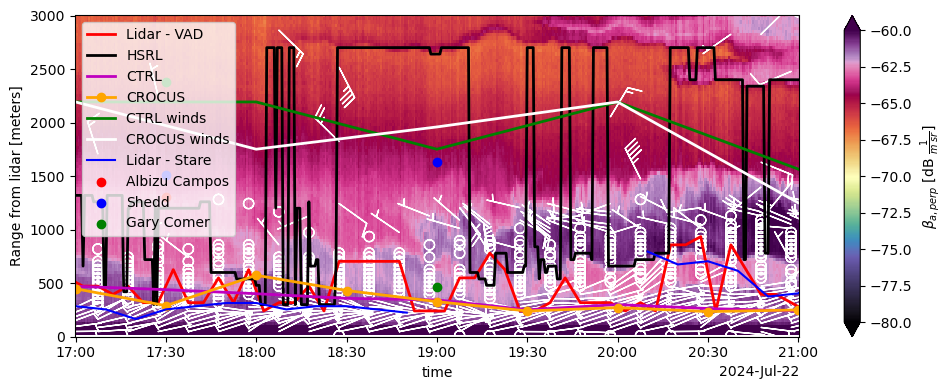

In [137]:
plot_every=2
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
(10*np.log10(hsrl["atten_beta_a_backscat"])).sel(time=slice('2024-07-22T17:00:00',
                                                               '2024-07-22T21:00:00')).T.plot(
    vmax=-60, cmap='ChaseSpectral', vmin=-80,
    cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),
    y="height")
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contourf(
       levels=[0.04, 100], alpha=0, hatches=['', '//', '/'], add_colorbar=False, 
    label='PBL Tucker method', ax=ax)
variance_ds['atmos_variance'].where(variance_ds['noise_variance'] < 0.2).sel(
    time=slice(start_time, end_time)).T.plot.contour(
       levels=[0, 0.04], colors=['k'], add_colorbar=False,  ax=ax)
x, y = np.meshgrid(vert_profs["time"].values, vert_profs["height"].values, indexing='ij')
ax.barbs(x[::plot_every, ::plot_every], 
          y[::plot_every, ::plot_every],
          vert_profs["u"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every], 
          vert_profs["v"].where(vert_profs["residual"] < residual_thresh)[::plot_every, ::plot_every],
        color='w')
ax.plot(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        color='r', linewidth=2, 
        label="Lidar - VAD")
ax.plot(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', linewidth=2,
        label="HSRL")
ax.plot(times_wrf_pbl, myj_pbl_ctrl, label="CTRL", color='m', linewidth=2, )
ax.plot(times_wrf_pbl, myj_pbl_crocus, label="CROCUS", color='orange', marker='o', linewidth=2)
ax.plot(times_wrf_pbl_hr, pbl_heights_myj_ctrl, label="CTRL winds", color='g', linewidth=2)
ax.plot(times_wrf_pbl_hr, pbl_heights_myj_crocus, label="CROCUS winds", color='w', linewidth=2)
plt.plot(variance_ds['time'].values, pblh_lidar, color='b', label="Lidar - Stare")
for j, i in enumerate([1, 2, 3, 4]):
    launch_time = i
    sonde = pbl_heights.isel(launch_time=launch_time)
    sonde["Dewp"].attrs["units"] = "degC"
    
    if j == 0:
        ax.scatter(sonde["launch_time"].values, sonde["pblht_liu_liang"].values, color='r', label="Albizu Campos")
    else:
        ax.scatter(sonde["launch_time"].values, sonde["pblht_liu_liang"].values, color='r')
    shedd = xr.open_dataset(file_list_shedd[i])
    shedd = act.retrievals.calculate_pbl_liu_liang(shedd)
    if j == 0:
        ax.scatter(sonde["launch_time"].values, shedd["pblht_liu_liang"].values, color='b', label="Shedd")
    else:
        ax.scatter(sonde["launch_time"].values, shedd["pblht_liu_liang"].values, color='b')
    shedd.close()
    comer = xr.open_dataset(file_list_comer[i])
    lapse_rate = comer["tdry"].diff(dim="time") / (comer["alt"].diff(dim="time") * 1e-3)
    comer = comer.where(lapse_rate > -100, drop=True)
    comer = act.retrievals.calculate_pbl_liu_liang(comer)
    if j == 0:
        ax.scatter(sonde["launch_time"].values, comer["pblht_liu_liang"].values, color='g', label="Gary Comer")
    else:
        ax.scatter(sonde["launch_time"].values, comer["pblht_liu_liang"].values, color='g')
    comer.close()
ax.set_ylim([0, 3000])
ax.legend(loc="upper left")
#ax.set_title('MYJ Model run')
fig.tight_layout()
fig.savefig('hsrl_with_estimates_myj12to3.png', bbox_inches='tight')
plt.ylim([0, 3000])

<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_8602/871040582.py:8: SyntaxWarning: invalid escape sequence '\ '
  cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),


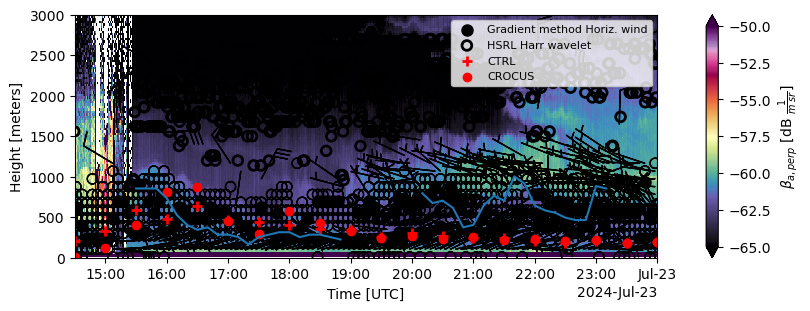

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), layout="constrained")
start_time = '2024-07-22T14:30:00'
end_time = '2024-07-23T00:00:00'
plot_every=5
residual_thresh = 1
(10*np.log10(hsrl["atten_beta_a_backscat"])).sel(time=slice(start_time, end_time)).T.plot(
    vmax=-50, cmap='ChaseSpectral', vmin=-65,
    cbar_kwargs=dict(label="$\\beta_{a,perp}$ [dB $\\frac{1}{m\ sr}$]"),
    y="height")
ax.plot(variance_ds['time'].values, pblh_lidar)
x, y = np.meshgrid(vert_profs["time"].sel(time=slice(start_time, end_time)).values,
                   vert_profs["height"].values, indexing='ij')
ax.barbs(x[::, ::plot_every], 
          y[::, ::plot_every],
          vert_profs["u"].sel(time=slice(start_time, end_time)).where(vert_profs["wind_speed_error"] < residual_thresh)[::, ::plot_every], 
          vert_profs["v"].sel(time=slice(start_time, end_time)).where(vert_profs["wind_speed_error"] < residual_thresh)[::, ::plot_every])
ax.scatter(ds_wind_harr["resampled_time"].values, pbl_heights_lidar_vads,
        edgecolors='black', color='k', linewidth=2, s=49,
        label="Gradient method Horiz. wind")
ax.scatter(hsrl_harr["resampled_time"].values, hsrl_pbl_heights,
        color='k', facecolors='none', edgecolors='black', linewidth=2, s=49,
        label="HSRL Harr wavelet")
ax.scatter(times_wrf_pbl, myj_pbl_ctrl, label="CTRL", color='r', linewidth=2, s=49, marker='+')
ax.scatter(times_wrf_pbl, myj_pbl_crocus, label="CROCUS", color='r', marker='o')
ax.set_ylim([0, 3000])
ax.legend(loc="upper right", fontsize=8)
ax.set_xlim([np.datetime64(start_time), np.datetime64(end_time)])
ax.set_xlabel('Time [UTC]')
#fig.tight_layout()
fig.savefig('hsrl_with_estimates_myj9to12.png', bbox_inches='tight')

In [45]:
hsrl

<xarray.Dataset> Size: 233MB
Dimensions:                                (calibration: 3,
                                            calibration_altitude: 509,
                                            time: 1298, mean_time: 1298,
                                            raw_time: 2935, altitude: 501,
                                            bin_range: 2034, profile_time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 10kB 2024-07...
  * mean_time                              (mean_time) datetime64[ns] 10kB 20...
  * raw_time                               (raw_time) datetime64[ns] 23kB 202...
  * altitude                               (altitude) float32 2kB 248.6 ... 1...
    height                                 (altitude) float32 2kB ...
Dimensions without coordinates: calibration, calibration_altitude, bin_range,
                                profile_time
Data variables: (12/66)
    base_time                              datetime64[ns] 8B ...
    sonde_times                            (calibration) datetime64[ns] 24B ...
    new_cal_times                          (calibration) datetime64[ns] 24B ...
    top_alt_sounding                       (calibration) float32 12B ...
    temperature_profile                    (calibration, calibration_altitude) float32 6kB ...
    pressure_profile                       (calibration, calibration_altitude) float32 6kB ...
    ...                                     ...
    profile_beta_a_backscat_parallel       (profile_time, altitude) float32 2kB ...
    profile_beta_a_backscat_perpendicular  (profile_time, altitude) float32 2kB ...
    profile_beta_a_backscat                (profile_time, altitude) float32 2kB ...
    profile_Na                             (profile_time, altitude) float32 2kB ...
    profile_Nm                             (profile_time, altitude) float32 2kB ...
    profile_Ncp                            (profile_time, altitude) float32 2kB ...
Attributes: (12/131)
    dpl_py_template:                                                         ...
    dpl_py_template_version:                                                 ...
    time_zone:                                                               ...
    codeversion:                                                             ...
    codedate:                                                                ...
    shellb3_distribution_version:                                            ...
    ...                                                                                   ...
    hsrl_processing_parameter__wfov_corr__time_filter_order:                 ...
    hsrl_processing_parameter__wfov_corr__correct_below_range:               ...
    hsrl_processing_parameter__wfov_corr__min_fit_range:                     ...
    hsrl_processing_parameter__wfov_corr__z_norm_interval:                   ...
    hsrl_processing_parameter__wfov_corr__enable_z_fit:                      ...
    hsrl_processing_parameter__alternate_cal_dir__full_dir_path:             ...